# Amazon (Text Modality)

In [2]:
import pandas as pd
import sys
sys.path.append("D:/COmparative_Study_of_Multimodal_Represenations/src")

from comparative.models.classical.early_fusion import EarlyFusionClassifier
from comparative.datasets.amazon_datamodule import AmazonDataModule
import torch
import pytorch_lightning as pl
from comparative.evaluation.metrics import compute_classification_metrics
from comparative.evaluation.latent_analysis import compute_umap, compute_silhouette
from comparative.evaluation.visualization import plot_umap
import random
from transformers import AutoTokenizer
from comparative.evaluation.visualization import plot_attention_map
import matplotlib.pyplot as plt
import numpy as np
from comparative.models.classical.late_fusion import LateFusionClassifier
from comparative.datasets.amazon_datamodule import AmazonDataModule

# clip
import os
from pathlib import Path

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import umap

import seaborn as sns

import pytorch_lightning as pl

from comparative.models.transformers.clip_module import CLIPTextOnlyClassifier # project module
import os, sys, json, random, math, textwrap
from pathlib import Path
# print("Lightning:", pl.__version__)


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Reading the metrics data logged at the time of training 
metrics_df = pd.read_csv("D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/lightning_logs/amazon_classical_early/version_0/metrics.csv")
display(metrics_df.tail(10))  # View last 10 rows for final epochs

,epoch,step,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
1572,9,31099,NaN,1.00000,NaN,0.001858,NaN,NaN
1573,9,31119,NaN,1.00000,NaN,0.009244,NaN,NaN
1574,9,31139,NaN,1.00000,NaN,0.003171,NaN,NaN
1575,9,31159,NaN,1.00000,NaN,0.003057,NaN,NaN
1576,9,31179,NaN,0.96875,NaN,0.021858,NaN,NaN
1577,9,31199,NaN,1.00000,NaN,0.004877,NaN,NaN
1578,9,31219,NaN,1.00000,NaN,0.000138,NaN,NaN
1579,9,31239,NaN,1.00000,NaN,0.000226,NaN,NaN
1580,9,31249,NaN,NaN,NaN,NaN,0.99925,0.002822
1581,9,31249,0.99828,NaN,0.005536,NaN,NaN,NaN


As the validation hasn't been logged, we will check how it works on unseen test data

## 1. Early Fusion 

In [4]:
test_df = pd.read_csv("D:/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/test.csv")
display(test_df.shape)  # test set shape 

(400000, 2)

In [5]:
val_df= pd.read_csv("D:/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/val.csv")
display(val_df.shape)  # validation set shape

(360000, 2)

#### Performance on unseen (test) data 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = EarlyFusionClassifier.load_from_checkpoint(
    "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_classical_early/last.ckpt",
    map_location=device,  
)
model.eval()
model.to(device)

dm = AmazonDataModule( # loeading data module
    data_dir="D:/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon",
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,  
    max_len=128,
    num_workers=8
)
dm.setup("test") 

In [ ]:
device = next(model.parameters()).device

test_loader = dm.test_dataloader()
all_logits = []
all_labels = []

num_samples = 25000
sample_count = 0

with torch.no_grad():
    for batch in test_loader:
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)

        logits = model(batch)

        all_logits.append(logits.detach().cpu().numpy())
        all_labels.append(batch["label"].detach().cpu().numpy())

        sample_count += logits.shape[0]
        if sample_count >= num_samples:
            break


In [ ]:
y_pred = np.concatenate([x.argmax(1) for x in all_logits])[:num_samples]
y_true = np.concatenate(all_labels)[:num_samples]

In [13]:
metrics = compute_classification_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.9428, 'precision': 0.9428026716068642, 'recall': 0.9428, 'f1': 0.9427971756202361, 'confusion_matrix': array([[9193,  593],
       [ 551, 9663]], dtype=int64)}


Balanced performance: precision ≈ recall ≈ F1 ≈ accuracy, which means that the model isn't biased toward one class. Both classes are well-learned, most samples are correctly classified, error counts are low (593 and 551), these errors are nearly symmetrical between 2 classes, which means that there is no major imbalance or systematic bias. 


The EARLY FUSION achieves high accuracy (94.28%) and F1, with balanced error rates between classes. It can capture sentiment with minimal bias and strong generalization.

#### Semantic Analysis

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


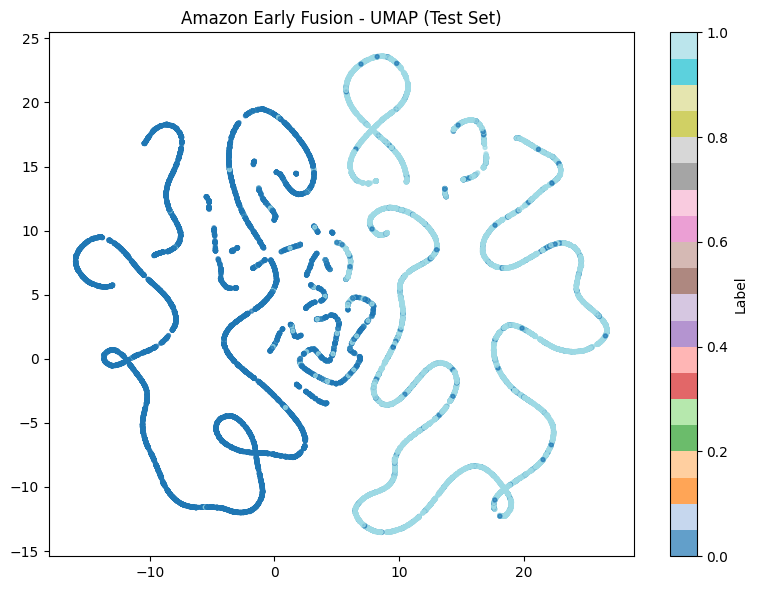

Silhouette score (UMAP): 0.658


In [14]:
device = next(model.parameters()).device  

# extracting embeddings from model for test set
features = []
sample_count = 0
num_samples = len(y_true)  

with torch.no_grad():
    for batch in test_loader:
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)

        # building only the inputs that the encoder expects
        encoder_inputs = {
            k: batch[k]
            for k in ["input_ids", "attention_mask", "token_type_ids"]
            if k in batch
        }

        encoder_out = model.encoder(**encoder_inputs)         # getting encoder outputs (CLS token)

        cls_emb = encoder_out.last_hidden_state[:, 0, :].cpu().numpy()         # using the [CLS] token embedding (first token)
        features.append(cls_emb)

        sample_count += cls_emb.shape[0]
        if sample_count >= num_samples:
            break

features = np.concatenate(features)[:num_samples] # stack all featuares and truncate to exactly num_samples

umap_emb = compute_umap(features)
plot_umap(umap_emb, labels=y_true, title="Amazon Early Fusion: UMAP (Test Set)")
sil_score = compute_silhouette(umap_emb, y_true)
print(f"Silhouette score (UMAP): {sil_score:.3f}")


UMAP Plot for Early fusion: 2 clusters (they are mostly distinct), each mostly made up of points with the same label (color). These 2 colors correspond to 2 sentiment classes (0-neg, 1-pos). Clear separation, with minimal mixing, which suggests that the model has learned to encode each sentiment into a distinct part of its latent space.

Result: models' final-layer features strongly separate 2 sentiment classes, even without supervision in the UMAP projection

Silhouette Score of 0.658: strong, meaningful class separation in the learned space.


* Note: "Silhouette score measures how “tightly” points of the same class are grouped, vs how far apart different classes are. Values > 0.5 are considered good, > 0.7 is excellent for real-world data"

#### Interpretation Analysis 
Case study of misclassification and correct classification, in order to see how model understands data:  

1144 misclassified samples

In [17]:
mis_idx = np.where(y_pred != y_true)[0]
print(f"Number of misclassified samples: {len(mis_idx)}")  # total misclassified samples

sampled = random.sample(list(mis_idx), min(5, len(mis_idx)))
print("Sample misclassified indices:", sampled) # some samples (indices of misclassified samples)

Number of misclassified samples: 1144
Sample misclassified indices: [8635, 112, 11352, 4102, 6958]


In [18]:
# some misclassified samples
test_df = pd.read_csv("D:/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/test.csv")

for idx in sampled:
    review = test_df.iloc[idx]
    pred = y_pred[idx]
    true = y_true[idx]
    print(f"Index: {idx}")
    print(f"True label: {true}, Predicted: {pred}")
    print("Review text:", review['full_text'])
    print("-"*60)

Index: 8635
True label: 0, Predicted: 1
Review text: does not work for phone calls. the microphone howls as soon as the phone connects to thenetwork. works great for games or radio.
------------------------------------------------------------
Index: 112
True label: 1, Predicted: 0
Review text: itten the elements of color. i was so very pleased to review the art book which arrived in pristine condition. i would have rated it in excellent condition, rather than very good. i would like to thank the person who made it possible, but have misplaced her name and address.
------------------------------------------------------------
Index: 11352
True label: 1, Predicted: 0
Review text: you feel like your on rollor coster. crichton writes a novel to full trill. congo is a major example of crichton's knowledge. congo is like a rollor coster. it start with a uphill battle of man over life. then it twistes and turn and when you thanks it's over, something new goes wrong.
---------------------------

In [27]:
for idx in [14336]:
    review1 = test_df.iloc[idx]
    pred1 = y_pred[idx]
    true1 = y_true[idx]
    print(f"Index: {idx}")
    print(f"True label: {true1}, Predicted: {pred1}")
    print("Review text:", review1['full_text'])

# one sample that we will look at

Index: 14336
True label: 0, Predicted: 1
Review text: no prayer for the dying. tailgunner-6/10holy smoke-6/10no prayer for the dying-7/10public enema number one-5/10fates warning-6/10run silent run deep-5/10hooks in you-5/10bring your daughter... to the slaughter-6/10mother russia-6/10


In [24]:
target_idx = 14336  # one of the misclassified samples
text = test_df.iloc[target_idx]["full_text"]

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(
    text,
    truncation=True,
    max_length=128,
    padding="max_length",
    return_tensors="pt",
)

device = next(model.parameters()).device  
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    output = model.encoder(**inputs, output_attentions=True)

    # output.attentions: [num_layers, batch, num_heads, seq, seq]
    att_map = output.attentions[-1][0, 0].cpu().numpy()  # last layer, head 0

    tokens = tokenizer.convert_ids_to_tokens(
        inputs["input_ids"][0].cpu().numpy()
    )

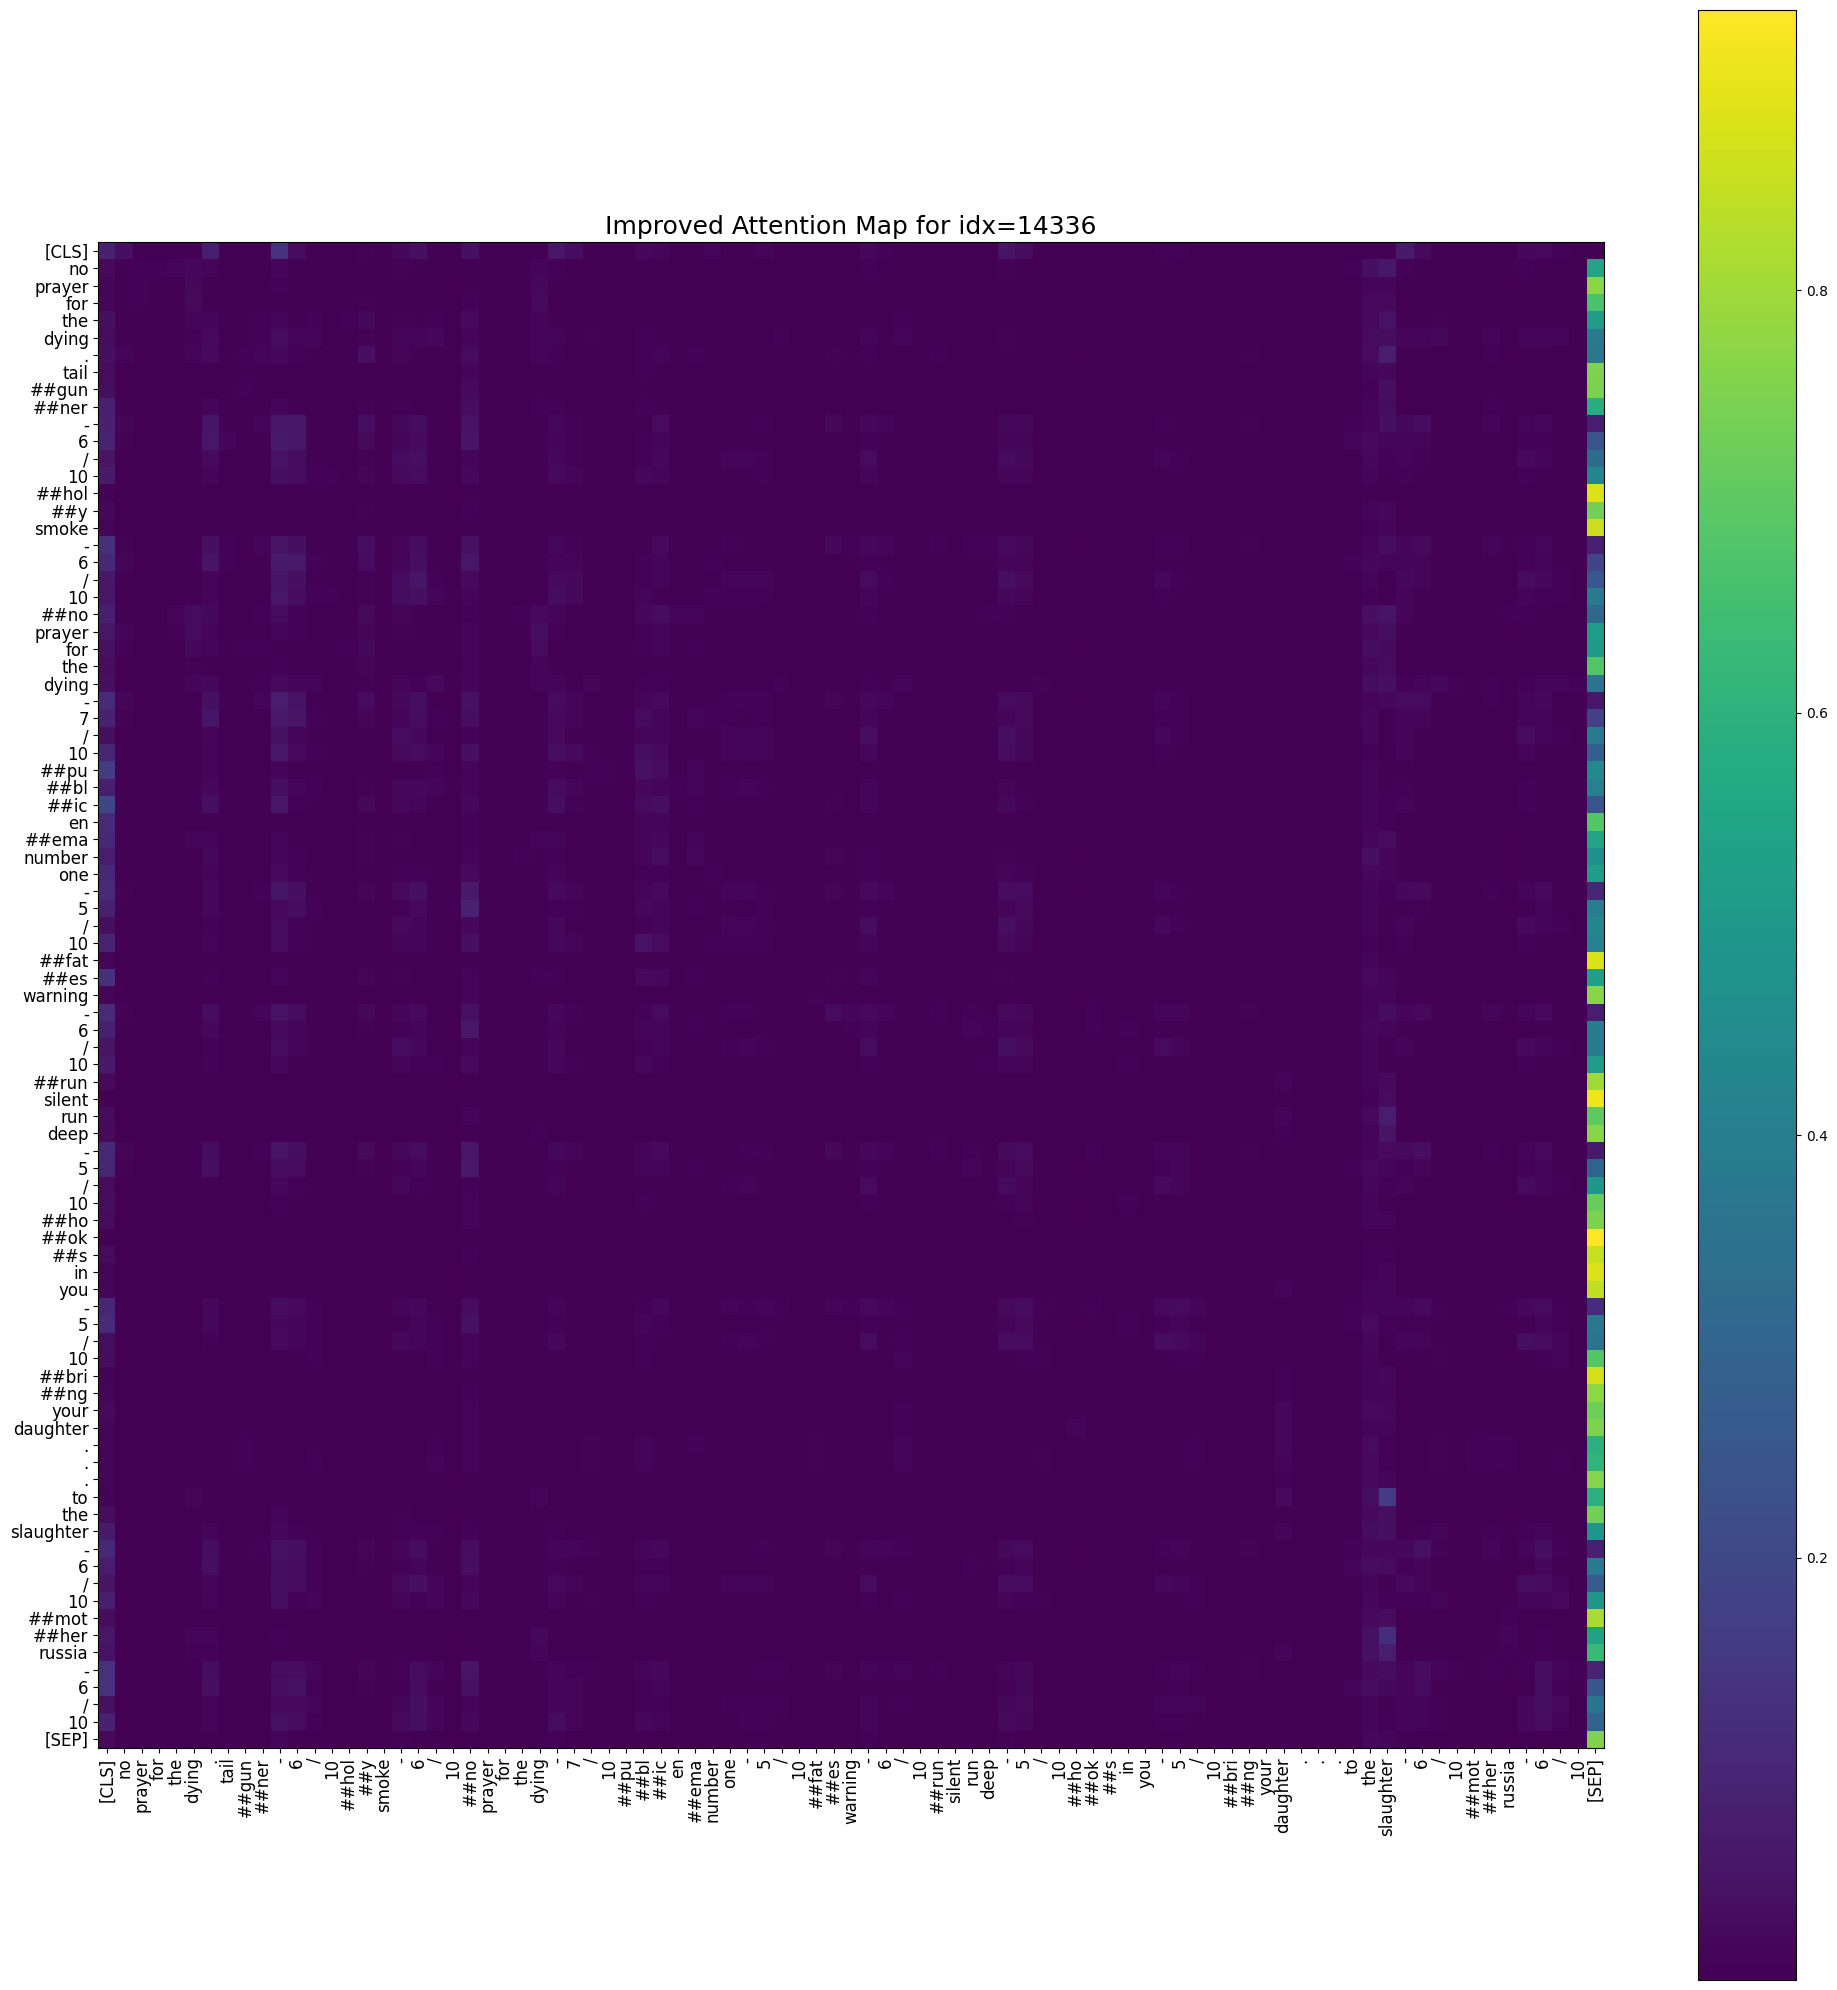

In [25]:
def plot_attention_map_better(att_map, tokens=None, title="Attention Map", figsize=(20, 20), save_path=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(att_map, cmap="viridis")
    plt.colorbar()
    if tokens is not None:
        n_tokens = min(len(tokens), att_map.shape[0])
        plt.xticks(range(n_tokens), tokens[:n_tokens], rotation=90, fontsize=12)
        plt.yticks(range(n_tokens), tokens[:n_tokens], fontsize=12)
    plt.title(title, fontsize=18)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Use only non-padding tokens for clarity
valid_len = sum([t != '[PAD]' for t in tokens])
plot_attention_map_better(att_map[:valid_len, :valid_len], tokens[:valid_len], title=f"Improved Attention Map for idx={target_idx}")

Attention map:

Most attention is concentrated on the [SEP] token at the end, other tokens receive some (but very low) attention, meaning that model doesn't focus on specific words, but instead using global structure. Key words don't get much attention -> model may not find strong sentiment cues in this text, which aligns with why it was misclassified.

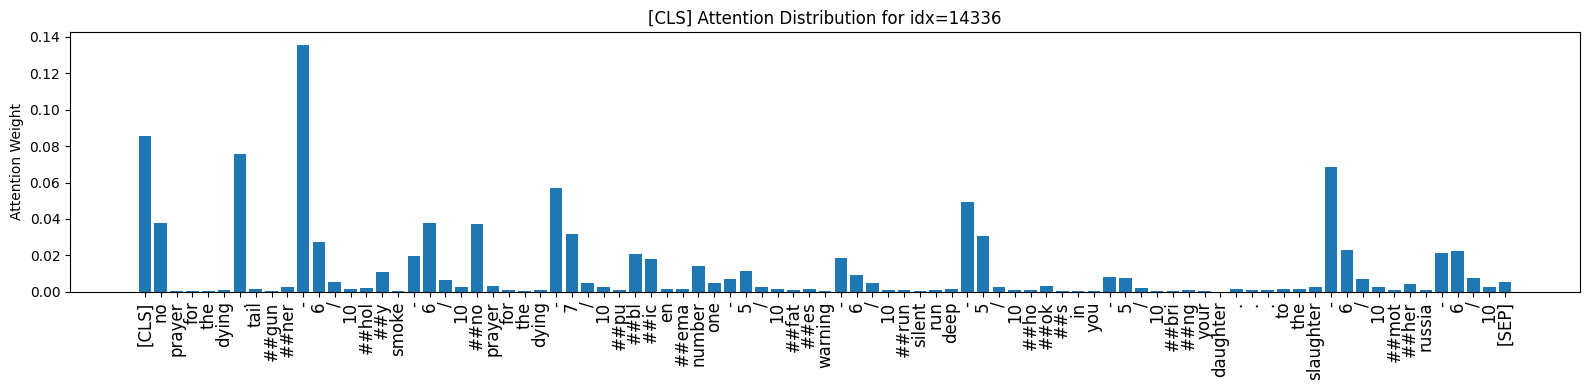

In [26]:
cls_row = att_map[0, :valid_len]  # Attention from [CLS] to every other token

plt.figure(figsize=(16, 4))
plt.bar(range(valid_len), cls_row)
plt.xticks(range(valid_len), tokens[:valid_len], rotation=90, fontsize=12)
plt.title(f"[CLS] Attention Distribution for idx={target_idx}")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

Attention map analysis for a misclassified review (index 14336) reveals that the model focuses mostly on the sequence-end token, with little attention to specific words. It explains misclassification: the review lacks strong sentiment cues and model does not identify any as especially informative. Such patterns are common in ambiguous or low-information reviews

In [53]:
# some correct samples

correct_idx = np.where(y_pred == y_true)[0]
print(f"Number of correct samples: {len(correct_idx)}")
sampled_correct = random.sample(list(correct_idx), min(5, len(correct_idx)))

for idx in sampled_correct:
    review = test_df.iloc[idx]
    pred = y_pred[idx]
    true = y_true[idx]
    print(f"Index: {idx}")
    print(f"True label: {true}, Predicted: {pred}")
    print("Review text:", review['full_text'])
    print("-"*60)

Number of correct samples: 18856
Index: 4448
True label: 1, Predicted: 1
Review text: tent play. easy to set up. big enough for several kids to play in. does take up a lot of room. just be careful with the rods when setting it up. we did get a tear. overall, the kids have fun playing with it. it's a good play tent for several kids and older kids as well.
------------------------------------------------------------
Index: 2639
True label: 0, Predicted: 0
Review text: non-stick coating wore off and is chipping after three months. i bought this pan with high expectations given the strong reviews from other customers but after a few months of use i am very disappointed. the pan takes several coats of oil to prevent food from sticking and now the non-stick surface is beginning to flake off. i always washed the pan by hand and never used anything other than plastic cooking utensils. the last non-stick pan i had was kirkland brand and it lasted four years.
------------------------------------

In [57]:
target_idx = 10504  # one of correctly classified samples
text = test_df.iloc[target_idx]["full_text"]

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(
    text,
    truncation=True,
    max_length=128,
    padding="max_length",
    return_tensors="pt",
)

device = next(model.parameters()).device 
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    output = model.encoder(**inputs, output_attentions=True)

    # output.attentions: [num_layers, batch, num_heads, seq, seq]
    att_map = output.attentions[-1][0, 0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(
        inputs["input_ids"][0].cpu().numpy()
    )

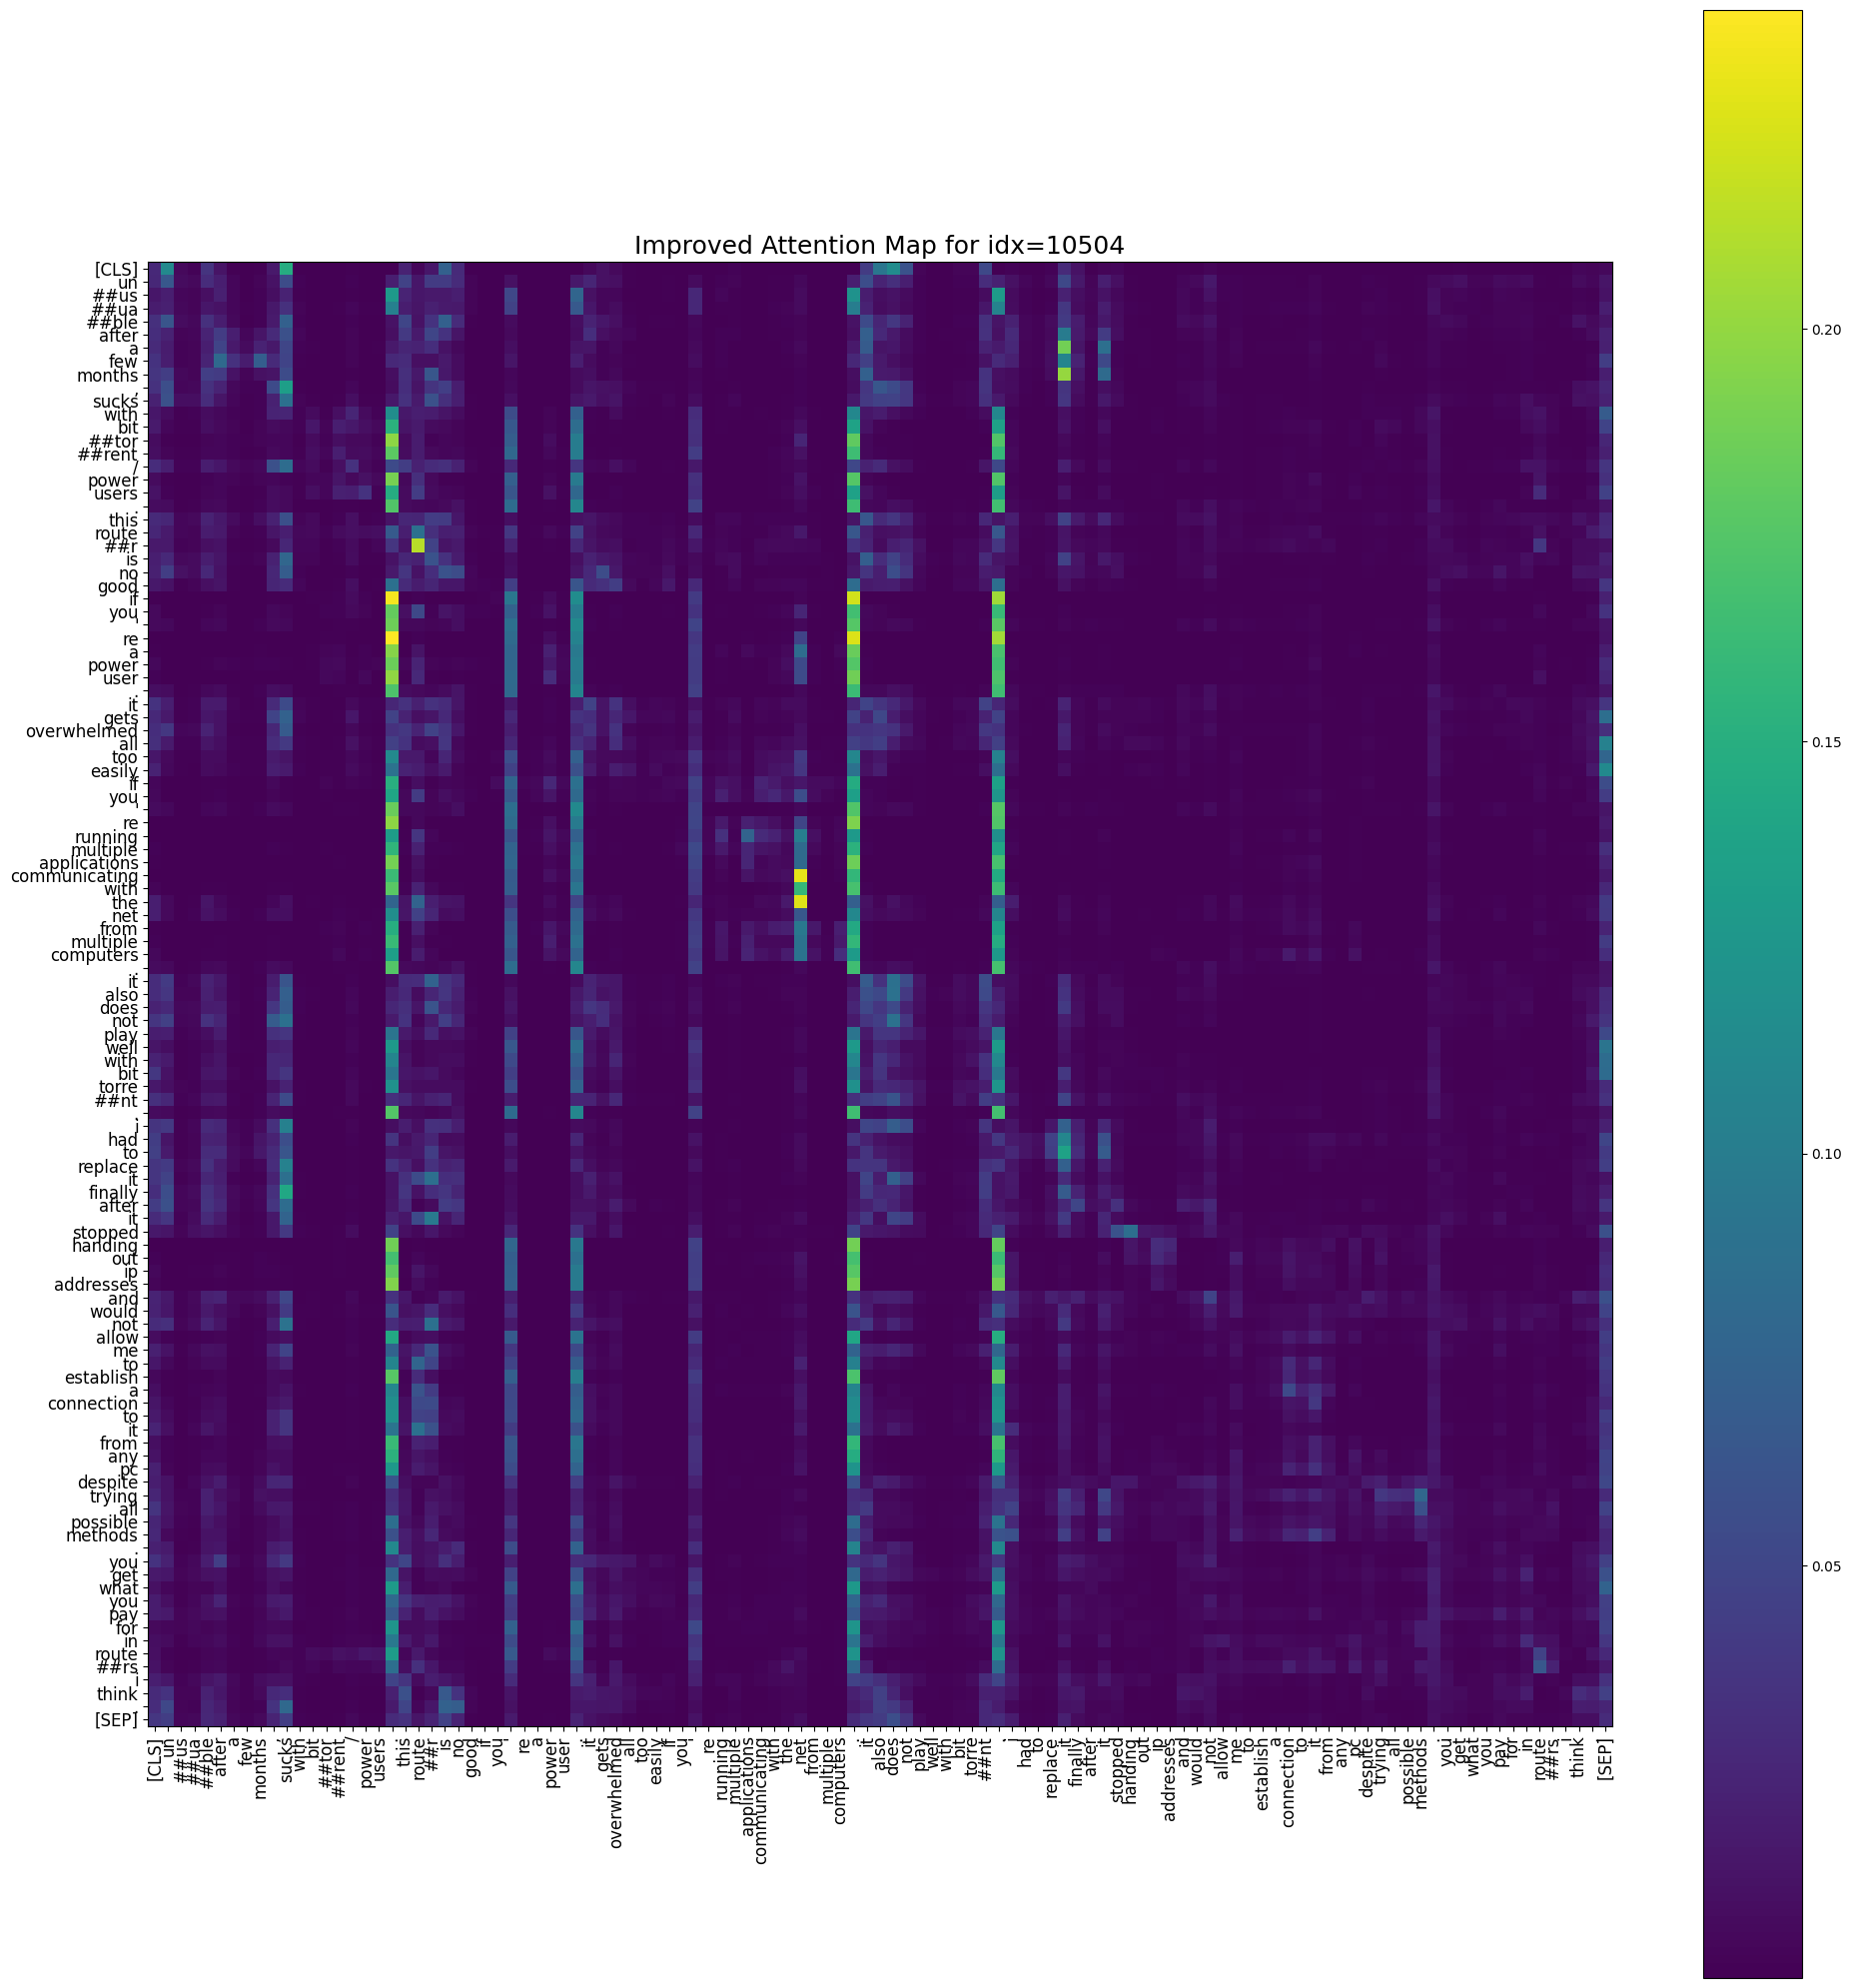

In [58]:
def plot_attention_map_better(att_map, tokens=None, title="Attention Map", figsize=(20, 20), save_path=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(att_map, cmap="viridis")
    plt.colorbar()
    if tokens is not None:
        n_tokens = min(len(tokens), att_map.shape[0])
        plt.xticks(range(n_tokens), tokens[:n_tokens], rotation=90, fontsize=12)
        plt.yticks(range(n_tokens), tokens[:n_tokens], fontsize=12)
    plt.title(title, fontsize=18)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Use only non-padding tokens for clarity
valid_len = sum([t != '[PAD]' for t in tokens])
plot_attention_map_better(att_map[:valid_len, :valid_len], tokens[:valid_len], title=f"Improved Attention Map for idx={target_idx}")

Full Attention Map (2D): here in heatmap there are distinct vertical and horizontal lines, which means that model is focusing attention on specific tokens across the sequence. Unlike a misclassified example, attention is more distributed, no dominant focus on just [SEP] or [CLS].

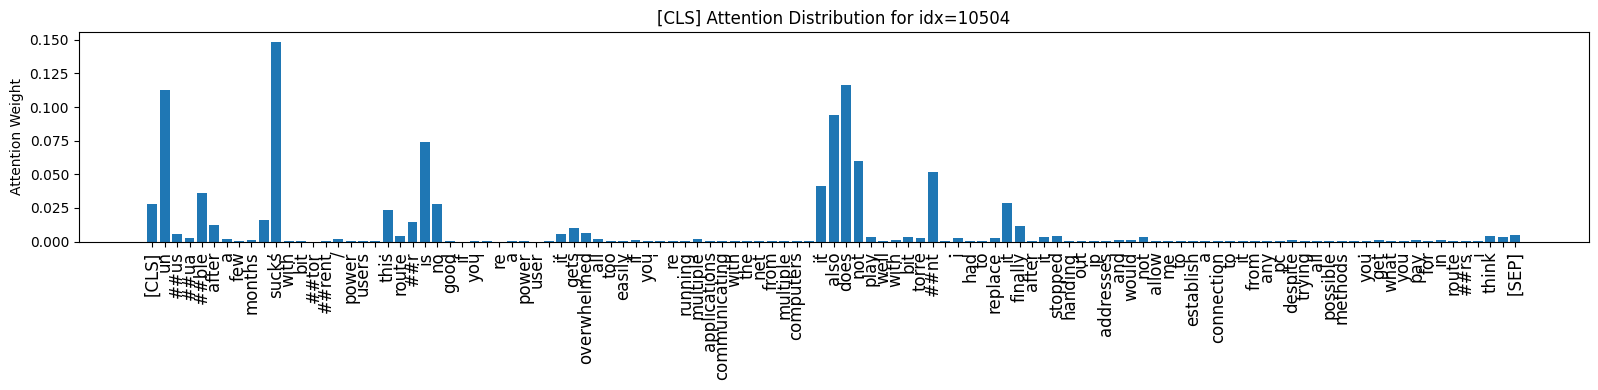

In [59]:
import matplotlib.pyplot as plt
cls_row = att_map[0, :valid_len]  # Attention from [CLS] to every other token

plt.figure(figsize=(16, 4))
plt.bar(range(valid_len), cls_row)
plt.xticks(range(valid_len), tokens[:valid_len], rotation=90, fontsize=12)
plt.title(f"[CLS] Attention Distribution for idx={target_idx}")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

[CLS] token’s attention is concentrated on several content words (not just one position or [SEP]): not good, sucs, overwhelmed, does, not, play, well, stopped, not. These words get more attention that others, they are sentiment-rich and highly relevant for classification: "not", “sucks”, “overwhelmed” suggests a negative review

Result:

In correctly classified reviews, the model's attention is distributed across sentimentally meaningful words, rather than being narrowly focused or diffused across padding and special tokens. The [CLS] attention peaks at negative descriptors ('not', 'overwhelmed', 'sucks'), meaning that model captures clear sentiment cues to make its prediction (in our example, negative review). Meanwhile, in misclassified case attention was either overly focused on special tokens or distributed across irrelevant words.

Correctly predicted: Attention aligns with key negative/positive phrases and sentiment cues

Misclassified: Attention is focused n special tokens or distributed across irrelevant words (no clear cues), mirroring the true challenge of ambiguous/low-signal data.

In [ ]:
# labeling each sample as correct or incorrect
is_correct = (y_pred == y_true).astype(int)  # 1 for correct, 0 for incorrect

#### UMAP Projection: Colored by Correctness

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


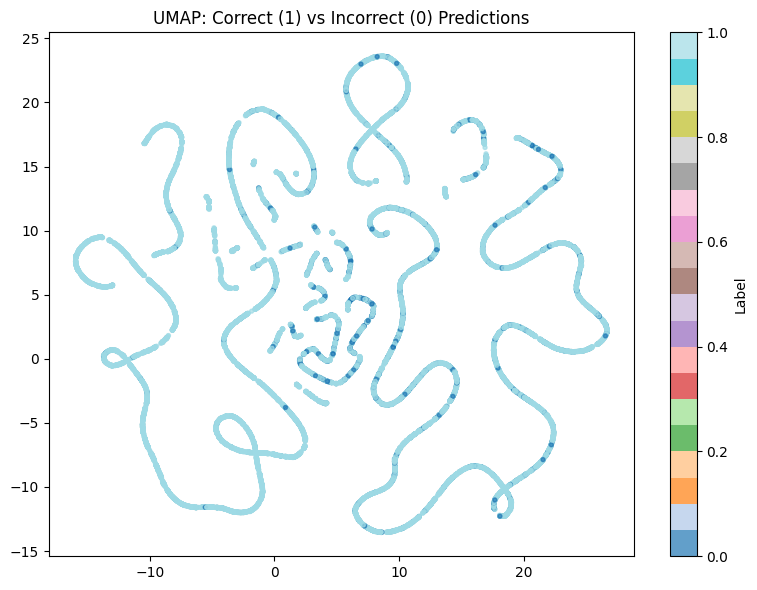

In [ ]:
umap_emb = compute_umap(features)
plot_umap(umap_emb, labels=is_correct, title="UMAP: Correct (1) vs Incorrect (0) Predictions")

Correct vs. Incorrect Predictions (UMAP): most points are correct (colored as 1, aligns with acc=94%), misclassified points are rare & not localized, i.e. no clear “error cluster” as misclassified samples are spread all over the latent space, not grouped into a particular region. By this, it can be concluded that model errors don't occur from a single ambiguous cluster, but are likely due to review-inherent ambiguity, sarcasm, or annotation noise. 

t-SNE Projection

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


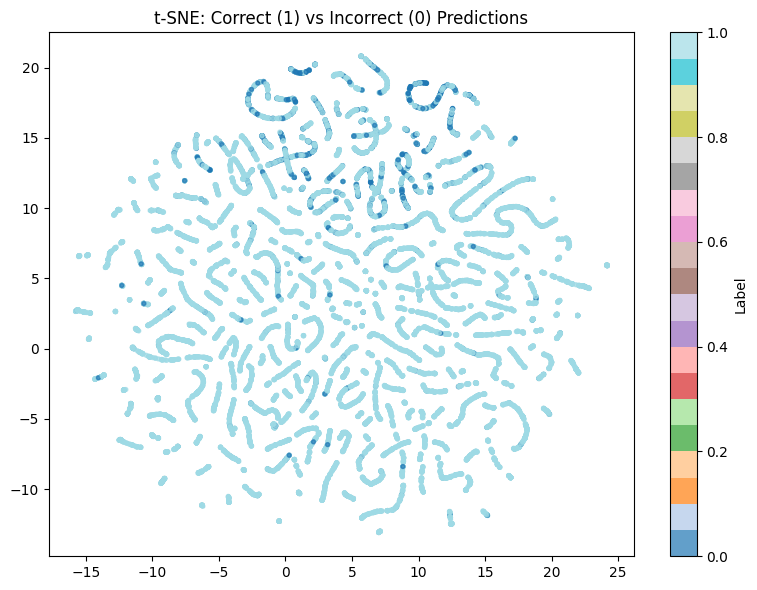

In [22]:
from comparative.evaluation.latent_analysis import compute_tsne

tsne_emb = compute_tsne(features)
plot_umap(tsne_emb, labels=is_correct, title="t-SNE: Correct (1) vs Incorrect (0) Predictions")

Correct vs. Incorrect Predictions (t-SNE): similarly as in UMAP, almost all points are the same color (correct, label=1), with rare, scattered points (incorr, label=0). No clear "error cluster" or dense region of mistakes. So, both projections show that model errors aren't concentrated in specific regions of latent space, but rather appear as isolated cases. By this, it can be concluded that there is a strong generalization - the model's learned representations reliably encode the vast majority of reviews.

In [ ]:
# Silhouette Scores by Correctness
sil_score_umap = compute_silhouette(umap_emb, is_correct)
print(f"Silhouette score (UMAP, correct/incorrect): {sil_score_umap:.3f}")
sil_score_tsne = compute_silhouette(tsne_emb, is_correct)
print(f"Silhouette score (t-SNE, correct/incorrect): {sil_score_tsne:.3f}")

Silhouette score (UMAP, correct/incorrect): -0.035
Silhouette score (t-SNE, correct/incorrect): 0.065


*Note: Silhouette score ranges from -1 (totally incorrect clustering, points are often closer to another cluster than their own) to 1 (perfectly separated clusters), 0 = random overlap.

Here both scores are close to 0. Correct and incorrect predictions are not separable in latent space -> NO CLUSTERING AMONG ERRORS, they're rather spread throughout. This is a sign of representational health - errors are not a result of the model grouping ambiguous cases into a problematic region of feature space. 

#### Per class error clusturing to check whether errors are concentrated in certain classes (e.g., only negatives or positives)

In [ ]:
# getting error indices per classes 0 neg, 1 pos
false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]
false_positives = np.where((y_true == 0) & (y_pred == 1))[0]
correct_negatives = np.where((y_true == 0) & (y_pred == 0))[0]
correct_positives = np.where((y_true == 1) & (y_pred == 1))[0]

Color vector for visaulization:

0 = Correct Negative

1 = False Positive (predicted positive, must be negative)

2 = False Negative (predicted negative, must be positive)

3 = Correct Positive

In [25]:
error_class = np.zeros_like(y_true)
error_class[false_positives] = 1
error_class[false_negatives] = 2
error_class[correct_positives] = 3

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


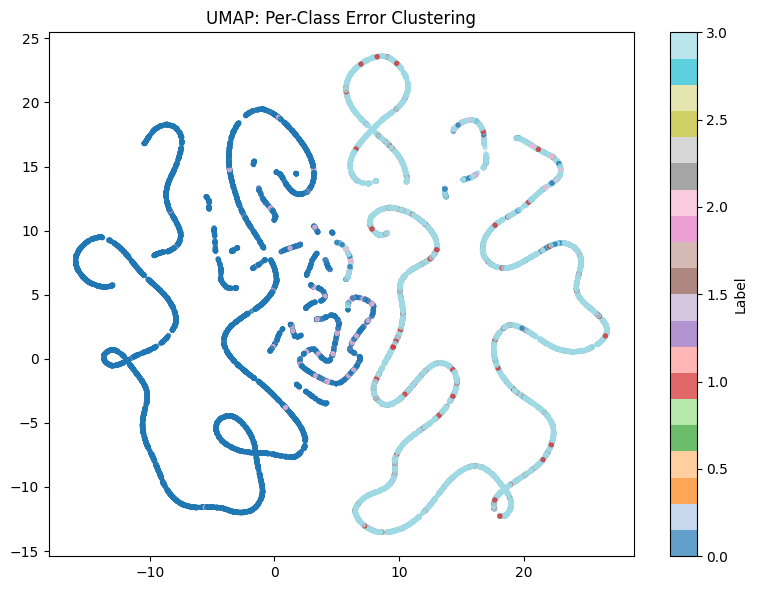

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


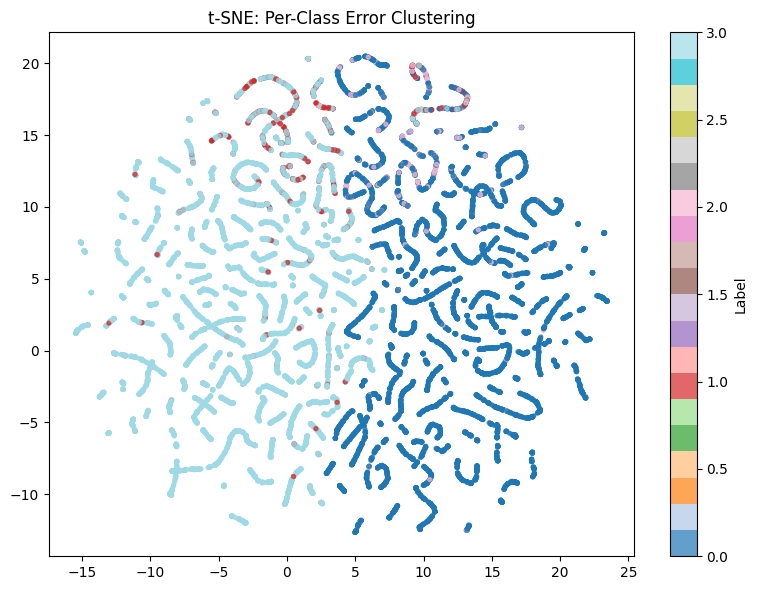

In [ ]:
# UMAP, t-SNE Projection colored by ERR CLASS

plot_umap(umap_emb, labels=error_class, title="UMAP: Per-Class Error Clustering")
plot_umap(tsne_emb, labels=error_class, title="t-SNE: Per-Class Error Clustering")

Correct preds (0 and 3) form almost all of points, false pos and false neg (1 and 2) are rare and scattered (some more errors at edges/boundaries).

1. well-defined regions for both classes (majority of test samples are classified correctly) -> model reliability is high for both classes

2. Errors are rare and scattered, no regions where errors accumulate (some at class border - ambiguity in sentiment near decision boundary).

In [ ]:
# Silhouette Score by Error Class

sil_score_umap = compute_silhouette(umap_emb, error_class)
sil_score_tsne = compute_silhouette(tsne_emb, error_class)
print(f"Silhouette score (UMAP, error class): {sil_score_umap:.3f}")
print(f"Silhouette score (t-SNE, error class): {sil_score_tsne:.3f}")

Silhouette score (UMAP, error class): 0.351
Silhouette score (t-SNE, error class): 0.221


Silhouette Scores for Error Class Clustering are moderate: some degree of separation between error/correct classes in latent space. Even if there are no tight clusters, they're still not random either. 
UMAP error class silhouette: 0.351
t-SNE error class silhouette: 0.221

Conclusion: meaningful but not perfect sepration between correct predictions and error types in latent space.

## 2. Late Fusion

1. Performance Metrics: Test accuracy, precision, recall, F1, confusion matrix.

2. Latent Space Analysis: UMAP & t-SNE (colored by label, then correctness).

3. Semantic/Cluster Analysis: Silhouette scores.

4. Errors: Per-class error clustering, attention case studies.

In [ ]:
# model and data
model = LateFusionClassifier.load_from_checkpoint("D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_classical_late/last.ckpt",
                                                  map_location=device,  
)
model.eval()
model.to(device)

# DataModule
dm = AmazonDataModule(
    data_dir="D:/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon",
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,
    max_len=128,
    num_workers=8
)
dm.setup("test")

In [ ]:
# first 25K samples from test
test_loader = dm.test_dataloader()
all_logits, all_labels, all_embeddings = [], [], []
num_samples, sample_count = 25000, 0

device = next(model.parameters()).device

with torch.no_grad():
    for batch in test_loader:
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
        logits = model(batch)
        # Get pooled features for latent analysis
        pooled = model.text_encoder(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        ).last_hidden_state[:, 0, :]
        all_logits.append(logits.cpu().numpy())
        all_labels.append(batch["label"].cpu().numpy())
        all_embeddings.append(pooled.cpu().numpy())
        sample_count += logits.shape[0]
        if sample_count >= num_samples:
            break

y_pred = np.concatenate([x.argmax(1) for x in all_logits])[:num_samples]
y_true = np.concatenate(all_labels)[:num_samples]
embeddings = np.concatenate(all_embeddings)[:num_samples]

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
#test
metrics = compute_classification_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.9411, 'precision': 0.9412181592398025, 'recall': 0.9411, 'f1': 0.9411061415116015, 'confusion_matrix': array([[9272,  514],
       [ 664, 9550]])}


| Metric            | Early Fusion | Late Fusion |
|-------------------|--------------|-------------|
| Accuracy        | 0.9428       | 0.9411      |
| Precision       | 0.9428       | 0.9412      |
| Recall          | 0.9428       | 0.9411      |
| F1 Score        | 0.9428       | 0.9411      |
| Confusion Matrix | [[9193,  593], <br> [ 551, 9663]] | [[9272,  514], <br> [ 664, 9550]] |


1. Both approaches are equally strong: the difference in metrics is less than 0.2%.

2. Error trade-offs differences: LF has less FP (514) but more FN (664). Early fusion has more FP (593) and fewer FN (551).

3. Both models are balanced: confusion matrices show symmetry, neither model is biased toward one class.

Conclusion: both fusion approaches perform well on Amazon dataset (text-only modality).

### Latent Space Analysis (UMAP, t-SNE, Silhouette)

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


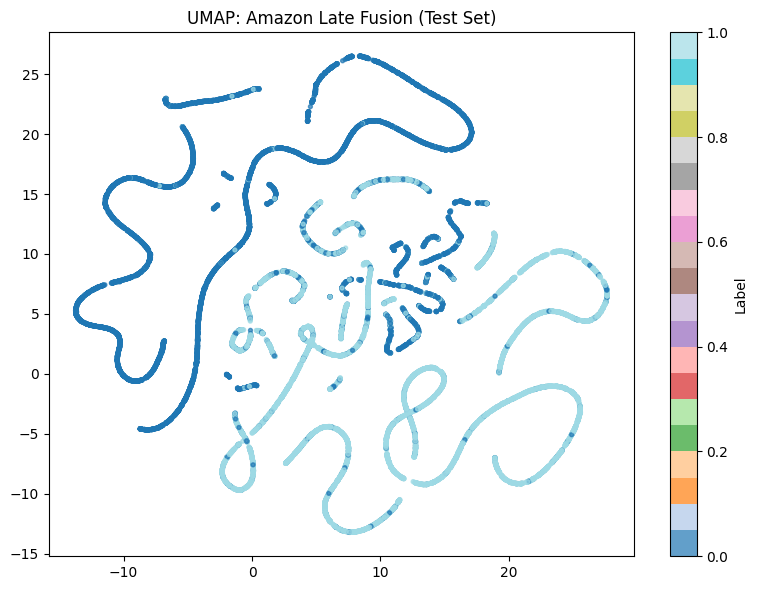

In [ ]:
#UMAP Projection Colored by True Label
umap_emb_late = compute_umap(embeddings)
plot_umap(umap_emb_late, labels=y_true, title="UMAP: Amazon Late Fusion (Test Set)")

Both clusters are smoothly separated. Each cluster corresponds to a single class, little mixing or overlap between these 2 class clusters (strong class separation).

The overall shape and separation are similar to Early fusion's UMAP, confirming that both architectures learn high-quality sentiment representations on this dataset (strong latent space alignment) for text-based sentiment analysis.

In [ ]:
#Silhouette Score (UMAP, by Label)
sil_score_late_umap = compute_silhouette(umap_emb_late, y_true)
print(f"Silhouette score (UMAP, by label): {sil_score_late_umap:.3f}")

Silhouette score (UMAP, by label): 0.619


This score of 0.617 confirms strong cluster separation latent space.

It means that
* points within each class cluster are tightly packed;
* points from different classes are far apart in the learned space.

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


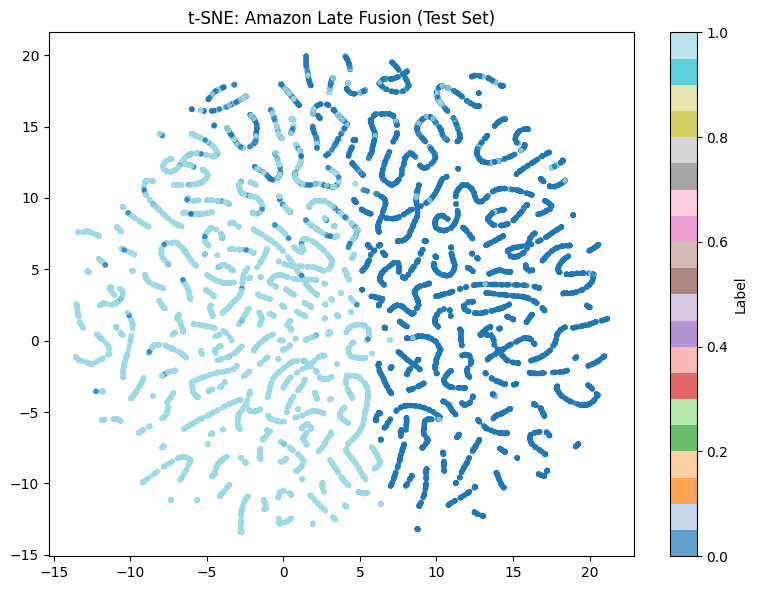

In [ ]:
#t-SNE Projection Colored by True Label
tsne_emb_late = compute_tsne(embeddings)
plot_umap(tsne_emb_late, labels=y_true, title="t-SNE: Amazon Late Fusion (Test Set)")

t-SNE projection further confirms robust separation of sentiment classes observed in UMAP. 2 distinct clusters dominate the plot, with each class occupying its own region in feature space and only minimal mixing at the decision boundary. 

In [ ]:
sil_score_late_tsne = compute_silhouette(tsne_emb_late, y_true) #Silhouette Score (t-SNE, by Label)
print(f"Silhouette score (t-SNE, by label): {sil_score_late_tsne:.3f}")

Silhouette score (t-SNE, by label): 0.404


Score of 0.406 means moderate separation, less than obtained in UMAP. t-SNE and UMAP are both nonlinear but:

* t-SNE preserves local structure (keeps nearby points close to each other), but doesn't preserve global distances well, so clusters that are far apart in the real data may appear much closer together in the visualization
* UMAP preserves both local and global structure better for class separation.

#### Error/Correctness Analysis in Latent Space

In [ ]:
#Correctness Label Vector
is_correct_late = (y_pred == y_true).astype(int)  # 1 = correct, 0 = incorrect

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


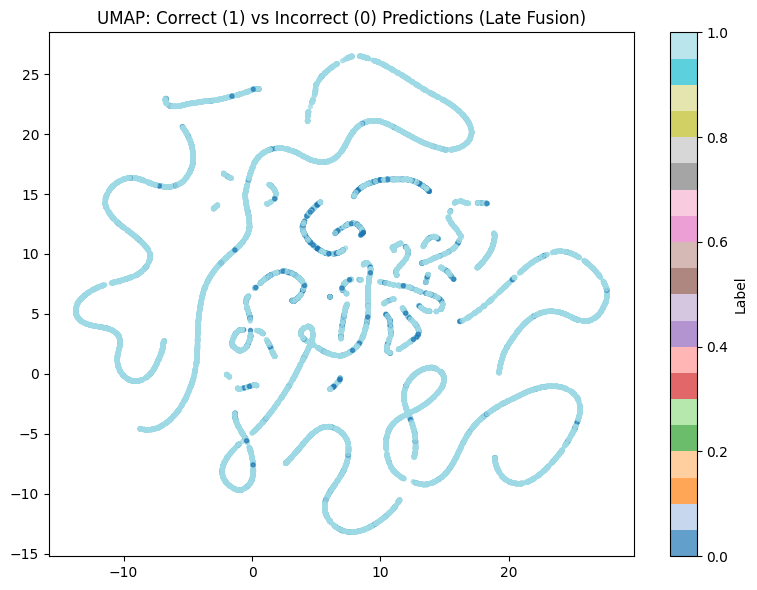

In [ ]:
#UMAP by Correctness
plot_umap(umap_emb_late, labels=is_correct_late, title="UMAP: Correct (1) vs Incorrect (0) Predictions (Late Fusion)")

In [ ]:
#by correctness
sil_score_late_umap_correct = compute_silhouette(umap_emb_late, is_correct_late)
print(f"Silhouette score (UMAP, correctness): {sil_score_late_umap_correct:.3f}")

Silhouette score (UMAP, correctness): 0.019


In this plot we see that almost all points are of the same color (1-correct), incorrect predictions (0-incorr) are rare w/ no danger region

This score of 0.019 (near 0) means there is almost no cluster structure for correctness. Errors aren't grouped, but rather distributed throughout the latent space (and they are likely due to inherent ambiguity in data or rare edge cases). 


Conclusion: almost all points are classified correctly, w/ only few erroes distributed across latent space. The silhouette score confirms that incorrect predictions don't form distinct or isolated cluster.

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


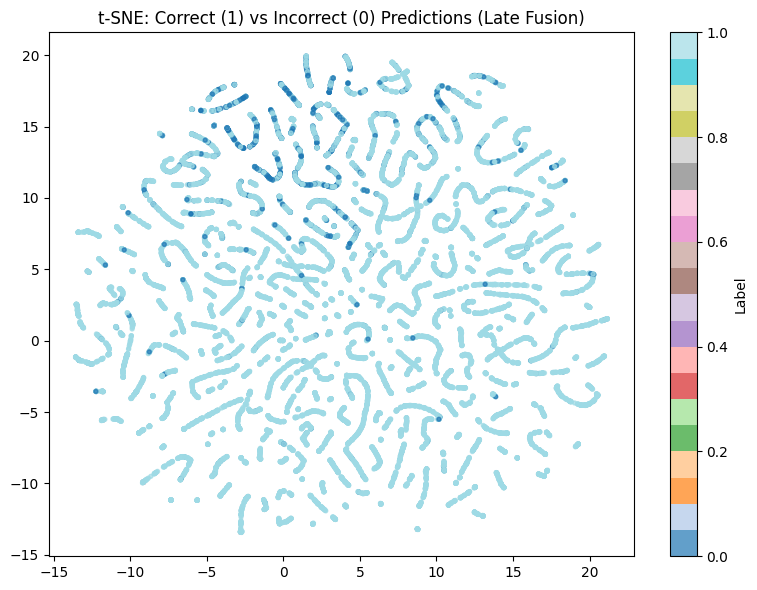

In [ ]:
#t-SNE by correctness
plot_umap(tsne_emb_late, labels=is_correct_late, title="t-SNE: Correct (1) vs Incorrect (0) Predictions (Late Fusion)")

In [44]:
sil_score_late_tsne_correct = compute_silhouette(tsne_emb_late, is_correct_late)
print(f"Silhouette score (t-SNE, correctness): {sil_score_late_tsne_correct:.3f}")

Silhouette score (t-SNE, correctness): 0.110


t-SNE projection supports findings from UMAP.

In [ ]:
# labeling error types

# 0 = negative, 1 = positive 
false_negatives_late = np.where((y_true == 1) & (y_pred == 0))[0]
false_positives_late = np.where((y_true == 0) & (y_pred == 1))[0]
correct_negatives_late = np.where((y_true == 0) & (y_pred == 0))[0]
correct_positives_late = np.where((y_true == 1) & (y_pred == 1))[0]

# 0 = correct neg, 1 = false pos, 2 = false neg, 3 = correct pos
error_class_late = np.zeros_like(y_true)
error_class_late[false_positives_late] = 1
error_class_late[false_negatives_late] = 2
error_class_late[correct_positives_late] = 3

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


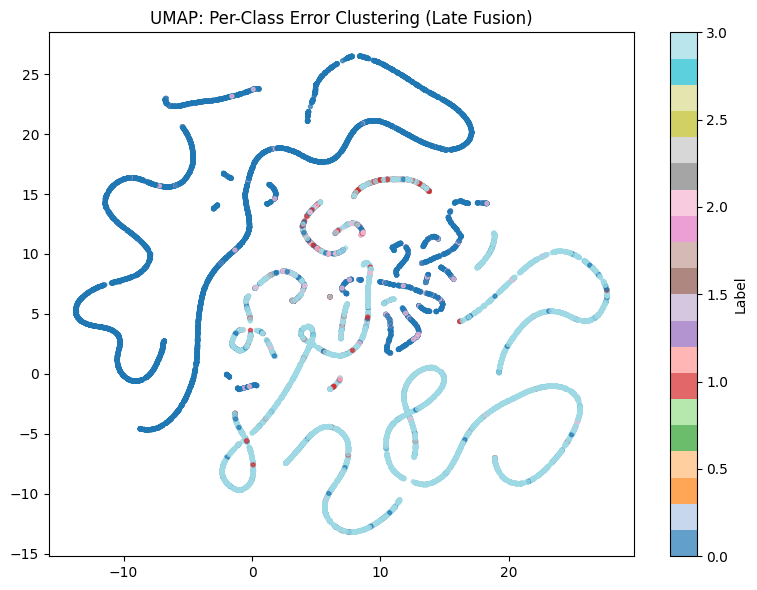

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


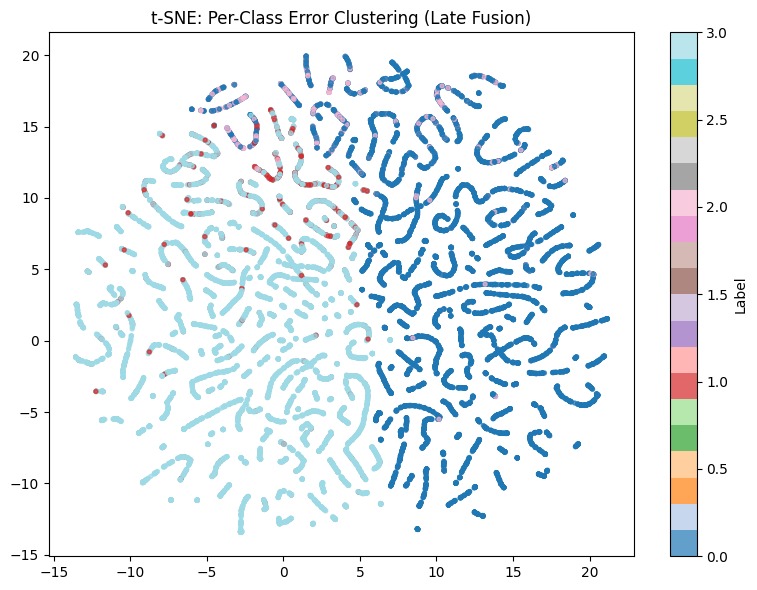

In [ ]:
# UMAP/t-SNE by err class

plot_umap(umap_emb_late, labels=error_class_late, title="UMAP: Per-Class Error Clustering (Late Fusion)")
plot_umap(tsne_emb_late, labels=error_class_late, title="t-SNE: Per-Class Error Clustering (Late Fusion)")

In [ ]:
#silhouette score by err class
sil_score_umap_error = compute_silhouette(umap_emb_late, error_class_late)
sil_score_tsne_error = compute_silhouette(tsne_emb_late, error_class_late)
print(f"Silhouette score (UMAP, error class): {sil_score_umap_error:.3f}")
print(f"Silhouette score (t-SNE, error class): {sil_score_tsne_error:.3f}")

Silhouette score (UMAP, error class): 0.341
Silhouette score (t-SNE, error class): 0.214


As can be seen from plots above, per-class error visualization shows 2 dominant class clusters, with misclassifications (FP and FN) ppearing as rare, scattered points along the decision boundary. No specific error regions and positive scores confirm that errors mainly occur in ambiguous, borderline cases rather than from representational errors.

In [ ]:
# fUrther analysis: looking iinto MISCLASSIFIED SAMPLES (FP and FN)
  

false_negatives_late = np.where((y_true == 1) & (y_pred == 0))[0]
false_positives_late = np.where((y_true == 0) & (y_pred == 1))[0]

sampled_fn = random.sample(list(false_negatives_late), min(3, len(false_negatives_late)))
sampled_fp = random.sample(list(false_positives_late), min(3, len(false_positives_late)))

test_df = pd.read_csv("D:/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/test.csv")


In [41]:
print("False Negatives (true positive, predicted negative):")
for idx in sampled_fn:
    review = test_df.iloc[idx]
    print(f"Index: {idx}")
    print("Review text:", review['full_text'])
    print("-" * 50)

print("False Positives (true negative, predicted positive):")
for idx in sampled_fp:
    review = test_df.iloc[idx]
    print(f"Index: {idx}")
    print("Review text:", review['full_text'])
    print("-" * 50)

False Negatives (true positive, predicted negative):
Index: 6958
Review text: flour. the flour was good, but because of the weight (50 lbs) they could have done a better job in taping the box shut. the box was banged up a bit, only one strip of tape was used.
--------------------------------------------------
Index: 629
Review text: pratchett review haiku. i've been trying to distill my reviews to seventeen syllables. here's an attempt.a tortoise falls fromthe sky. brutha must showthe heretics truth.
--------------------------------------------------
Index: 7811
Review text: working windows works. ... it arrived on friday, and was an easy read, with lots of diagrams and helpful hints. on sunday i attacked a 73 year old double hung window which had been painted shut for decades, and everything i encountered was just as described in the book. by the end of the day, the window had been reassembled and both sashes now function properly. my total out of pocket cost was less than $20, includ

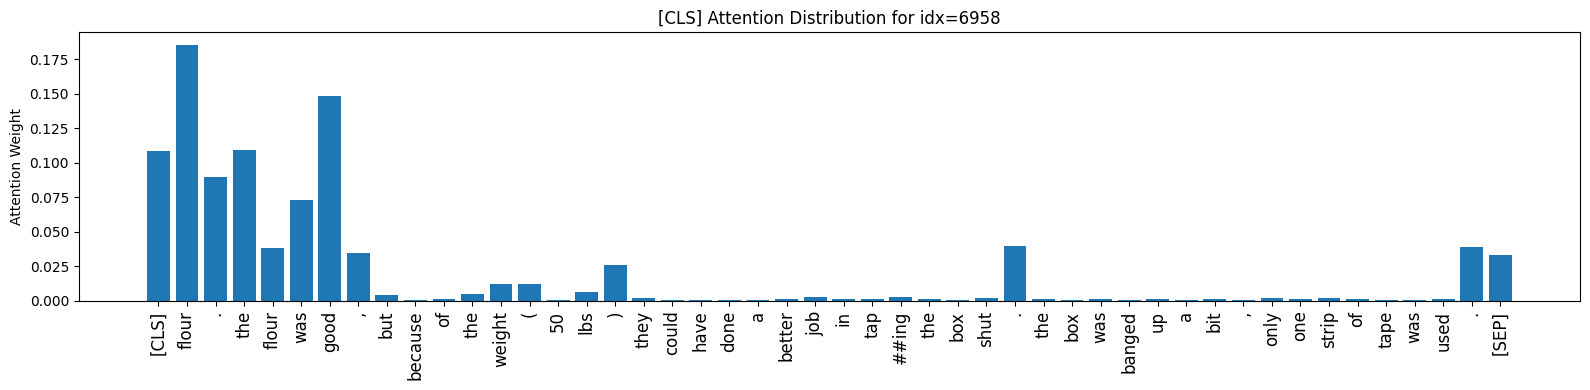

In [ ]:
# [CLS] attention map for 1 example of misclassified sample

idx = sampled_fn[0]  
text = test_df.iloc[idx]['full_text']
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(
    text,
    truncation=True,
    max_length=128,
    padding="max_length",
    return_tensors="pt"
)
inputs = {k: v.cuda() for k, v in inputs.items()}
with torch.no_grad():
    output = model.text_encoder(**inputs, output_attentions=True)
    att_map = output.attentions[-1][0, 0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

valid_len = sum([t != '[PAD]' for t in tokens])
import matplotlib.pyplot as plt
cls_row = att_map[0, :valid_len]
plt.figure(figsize=(16, 4))
plt.bar(range(valid_len), cls_row)
plt.xticks(range(valid_len), tokens[:valid_len], rotation=90, fontsize=12)
plt.title(f"[CLS] Attention Distribution for idx={idx}")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

Here in our example for a sample (index 6958: true=1, pred=0), attention map focuses more on "flour", "good", "flour was good". So model focuses on the initial sentiment "good", but then there are negative cues about box quality ("could have done better job in taping the box.." and "box was banged up.."). Sentiment becomes ambigious, because this review mixes both positive and negative assessment. Although model likely identiifies both cues, negative tone might overweight initial positive sentiment.

Other reviews above also show that in some reviews as there is no explicit sentiment, the model can't find standard sentiment cues (and guesses negative). This ambiguity or absence of sentiment signals is a known challenge for all models. This qualitative error analysis shows that most misclassifications come from ambiguity in reviews (mixed sentiment, not standard expressions or where sentiment is distributed across the whole review). 

## 3. Transformer Models: CLIP 

In [ ]:
PROJECT_ROOT = Path(r"D:\COmparative_Study_of_Multimodal_Represenations")

# sys.path.insert(0, str(PROJECT_ROOT / "src"))

CKPT_PATH = "D:/COmparative_Study_of_Multimodal_Represenations/results/amazon/clip_text/version_0/checkpoints/last.ckpt"

BATCH_SIZE = 64
MAX_LEN = 77   # CLIP text encoder max context length

os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)

print("Device:", device)
print("Checkpoint:", CKPT_PATH)

Device: cpu
Checkpoint: D:/COmparative_Study_of_Multimodal_Represenations/results/amazon/clip_text/version_0/checkpoints/last.ckpt


In [ ]:
PROJECT_ROOT = os.environ.get("PROJECT_ROOT", "D:/COmparative_Study_of_Multimodal_Represenations")  # paths
os.environ["PROJECT_ROOT"] = PROJECT_ROOT
sys.path.append(str(Path(PROJECT_ROOT) / "src"))

random.seed(42); np.random.seed(42); torch.manual_seed(42) # reproducibility

def hdr(s): 
    print("\n" + "="*len(s) + f"\n{s}\n" + "="*len(s))

In [ ]:
data_dir = Path(PROJECT_ROOT) / "data" / "processed" / "amazon"
train_csv = data_dir / "train.csv"
val_csv   = data_dir / "val.csv"

hdr("Ensure disjoint validation split")
assert train_csv.exists(), f"Missing {train_csv}"

if not val_csv.exists():
    df = pd.read_csv(train_csv) # creating simple, disjoint val split from the tail of train.csv (no overlap)
    n = len(df)
    val_size = max(20000, int(0.1 * n))  # either 10% or 20K (pick larger set)
    df_shuf = df.sample(frac=1.0, random_state=12345).reset_index(drop=True)
    df_val = df_shuf.iloc[:val_size].copy()
    df_tr  = df_shuf.iloc[val_size:].copy()
    new_train_csv = data_dir / "train_noval.csv" # new train/val 
    df_tr.to_csv(new_train_csv, index=False)
    df_val.to_csv(val_csv, index=False)
    print(f"Created disjoint val.csv with {len(df_val)} rows. New train file: {new_train_csv.name} ({len(df_tr)} rows).")
    train_csv = new_train_csv
else:
    print("Found existing val.csv. Assuming it's disjoint from train.csv.")

df_tr_head = pd.read_csv(train_csv, nrows=5)
print("Train columns:", list(df_tr_head.columns))


Ensure disjoint validation split
Found existing val.csv. Assuming it's disjoint from train.csv.
Train columns: ['full_text', 'label']


In [ ]:
from transformers import AutoTokenizer, CLIPTokenizerFast

name = "openai/clip-vit-base-patch16"
tok_auto = AutoTokenizer.from_pretrained(name)
tok_clip = CLIPTokenizerFast.from_pretrained(name)

print("Auto →", type(tok_auto).__name__, "| max_len:", tok_auto.model_max_length)
print("CLIP →", type(tok_clip).__name__, "| max_len:", tok_clip.model_max_length)

samples = [
    "great value, fast shipping!", 
    "terrible quality and slow support.", 
    "works as advertised, would buy again."
]
# enable padding so batched tensors have equal length
A = tok_auto(samples, truncation=True, padding=True, max_length=77, return_tensors="pt")
B = tok_clip(samples, truncation=True, padding=True, max_length=77, return_tensors="pt")

print("IDs equal? ", bool((A["input_ids"]==B["input_ids"]).all()))

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ntuke\.cache\huggingface\hub\models--openai--clip-vit-base-patch16. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Auto → CLIPTokenizerFast | max_len: 77
CLIP → CLIPTokenizerFast | max_len: 77
IDs equal?  True


In [ ]:
hdr("Instantiate DataModule with our explicit CSVs")

dm = AmazonDataModule(
    data_dir=str(data_dir),
    batch_size=64,
    num_workers=4,
    tokenizer_name="distilbert-base-uncased",  # ignored by CLIP but required by DM
    max_len=128,
)

if hasattr(dm, "train_csv_path"):
    dm.train_csv_path = str(train_csv)
if hasattr(dm, "val_csv_path"):
    dm.val_csv_path = str(val_csv)

dm.setup("fit")

# sanity check - batch must contain raw 'text' and 'label'
b = next(iter(dm.train_dataloader()))
print("Batch keys:", list(b.keys()))
assert "text" in b, "AmazonDataModule must emit raw 'text' for CLIP."
assert ("label" in b) or ("labels" in b), "Missing label/labels in batch."

# extract a single text item and convert to string if necessary
text_item = b["text"][0]
if isinstance(text_item, (bytes, bytearray)):
    example_text_str = text_item.decode(errors="ignore")
elif isinstance(text_item, str):
    example_text_str = text_item
elif "tokenizer" in globals() or "tok_clip" in globals() or "tok_auto" in globals():
    # if DM returned token ids as a tensor/array, decode using available tokenizer
    try:
        ids = None
        if isinstance(text_item, (list, tuple, np.ndarray)):
            ids = list(text_item)
        elif hasattr(text_item, "tolist"):
            ids = text_item.tolist()
        if ids is not None:
            if "tokenizer" in globals():
                example_text_str = tokenizer.decode(ids, skip_special_tokens=True)
            elif "tok_clip" in globals():
                example_text_str = tok_clip.decode(ids, skip_special_tokens=True)
            elif "tok_auto" in globals():
                example_text_str = tok_auto.decode(ids, skip_special_tokens=True)
            else:
                example_text_str = str(text_item)
        else:
            example_text_str = str(text_item)
    except Exception:
        example_text_str = str(text_item)
else:
    example_text_str = str(text_item)

# pick labels without using boolean ops on tensors
if "label" in b:
    label_tensor = b["label"]
else:
    label_tensor = b.get("labels")

# ensure label_tensor indexing works for numpy/torch tensors or lists
try:
    label_example = label_tensor[0]
except Exception:
    # fallback: convert to python type
    label_example = np.array(label_tensor)[0]

print("Example text:", textwrap.shorten(example_text_str, width=120))
print("Label example:", label_example)


Instantiate DataModule with our explicit CSVs


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch keys: ['input_ids', 'attention_mask', 'label', 'labels', 'text']
Example text: not for every day use! "tray" is a big waste!. i have been using this booster seat for a while now and it is [...]
Label example: tensor(0)


In [ ]:
from comparative.models.transformers.clip_module import CLIPTextOnlyClassifier

class CLIPTextOnlyClassifierEOS(CLIPTextOnlyClassifier):
    # this is Same as CLIPTextOnlyClassifier, but pools at last non-pad token (EOS-style)
    def forward(self, batch):
        # tokenize inside parent using the model's tokenizer
        tok = self._prep_text(batch)  # from base class (expects batch['text'])
        out = self.text_encoder(**tok)
        last = out.last_hidden_state                      # (B, L, D)
        mask = tok["attention_mask"]                      # (B, L)
        idx  = mask.sum(dim=1) - 1                        # last non-pad index
        emb  = last[torch.arange(last.size(0), device=last.device), idx]  # (B, D)
        logits = self.head(emb)
        if logits.shape[-1] != self._expected_out:
            raise RuntimeError(f"Head/output mismatch: {logits.shape[-1]} vs {self._expected_out}")
        return logits

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # hush the fork warning for HF tokenizers

In [ ]:
# labels must be 0/1
b = next(iter(dm.train_dataloader()))
y = (b.get("label") if "label" in b else b["labels"]).cpu().numpy()
print("Label set in a random batch:", np.unique(y))

# building balanced index list (256 neg + 256 pos) from train dataset
# we sample until we reach quotas, if first 512 are skewed/biased, accuracy won't change much.
neg_idx, pos_idx = [], []
for i in range(len(dm.train_ds)):
    yi = int(dm.train_ds[i]["label"])
    if yi == 0 and len(neg_idx) < 256:
        neg_idx.append(i)
    elif yi == 1 and len(pos_idx) < 256:
        pos_idx.append(i)
    if len(neg_idx) == 256 and len(pos_idx) == 256:
        break

tiny_idx = neg_idx + pos_idx
print(f"Tiny balanced slice size: {len(tiny_idx)} | neg={len(neg_idx)} pos={len(pos_idx)}")
assert len(tiny_idx) == 512, "Couldn't assemble a balanced 512-sample slice; increase caps or check labels."

Label set in a random batch: [0 1]
Tiny balanced slice size: 512 | neg=256 pos=256


In [ ]:
model = CLIPTextOnlyClassifierEOS(
    text_encoder_name="openai/clip-vit-base-patch16",
    classifier_hidden=512,
    num_labels=2, multilabel=False,
    lr=5e-5, weight_decay=0.01, eps=1e-8, max_steps=5000,
    freeze_text=True      # head-only to learn signal fast
).to(device)

model.train()

opt = torch.optim.AdamW(model.head.parameters(), lr=1e-3)

tiny_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(dm.train_ds, tiny_idx),
    batch_size=32, shuffle=True, num_workers=0, pin_memory=(device)
)

ce = torch.nn.CrossEntropyLoss()
acc_hist, loss_hist = [], []

for epoch in range(3):  # few passes over slice
    for step, batch in enumerate(tiny_loader):
        bb = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        # Manual forward/loss (avoid PL training_step + self.log warning)
        logits = model(bb)
        y = bb["label"]
        loss = ce(logits, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    # measure on the same tiny set at end of epoch
    with torch.no_grad():
        correct, total = 0, 0
        for batch in tiny_loader:
            bb = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            pred = model(bb).argmax(-1)
            correct += (pred == bb["label"]).sum().item()
            total   += bb["label"].numel()
        acc = correct / total
        acc_hist.append(acc); loss_hist.append(loss.item())
        print(f"epoch {epoch} | tiny-slice acc: {acc:.3f} | last loss: {loss.item():.4f}")

assert acc_hist[-1] > 0.90, "Tiny-slice did not overfit >0.9. If this fails, see the diagnostic cell below."

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 0 | tiny-slice acc: 0.885 | last loss: 0.6008
epoch 1 | tiny-slice acc: 0.924 | last loss: 0.3195
epoch 2 | tiny-slice acc: 0.961 | last loss: 0.1496


In [ ]:
# checking that 'text' strings are non-empty and reasonably long / short
txts = [dm.train_ds[i]["text"] for i in tiny_idx[:10]]
for t in txts:
    print(len(t.split()), "tokens ≈", t[:100].replace("\n"," "))

# token IDs sanity: ensure EOS/last-token pooling picks a non-pad token
from transformers import CLIPTokenizerFast
tok = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch16")
enc = tok([dm.train_ds[i]["text"] for i in tiny_idx[:4]], truncation=True, max_length=77, padding=True, return_tensors="pt")
mask = enc["attention_mask"]; idx = mask.sum(dim=1) - 1
print("Last-token indices:", idx.tolist())

# check that labels match text sentiment roughly (spot-check)
for i in tiny_idx[:5]:
    s = dm.train_ds[i]["text"]
    y = int(dm.train_ds[i]["label"])
    print("LABEL", y, "|", s[:180].replace("\n"," "))

33 tokens ≈ poor condition... great price. terrible condition. far worse than the description allotted. however,
51 tokens ≈ ok for ideas, but not for projects. i was disappointed as well. i expected projects i could build, b
27 tokens ≈ mediocre disc quality. a good movie but the dvd disc was not able to play smoothly all the way throu
42 tokens ≈ disappointed. i ordered the cd, hoping for one particular cut from the movie, "boom shak a lak - apa
142 tokens ≈ a ... robert jordan [imitation]. a young man. a disturbing encounter in the woods as he's off to the
47 tokens ≈ sub par pop/rock. if you want to hear the pop/rock music that is written with females in mind, this 
32 tokens ≈ i float, i guess. this life vest keeps me above water, i suppose, but it is way too big and unable t
25 tokens ≈ poor design. poor design.the sportline 330, if slightly bumped, will reset to zero. if you want a re
160 tokens ≈ i want to love this but.... i decided to switch from a salon brand to the damage t

In [66]:
class CLIPTextOnlyClassifierTwoWindow(CLIPTextOnlyClassifierEOS):
    """Encode first 77 and last 77 tokens separately (EOS pooled), average the two embeddings."""
    def _encode_text_eos(self, texts, take_head=True):
        # rough split by words; robust is to slice token IDs but this works well in practice
        seg = []
        for t in texts:
            words = t.split()
            piece = words[:128] if take_head else words[-128:]
            seg.append(" ".join(piece))
        tok = self.tokenizer(seg, truncation=True, max_length=77, padding=True, return_tensors="pt").to(self.device)
        out = self.text_encoder(**tok)
        last = out.last_hidden_state
        idx  = tok["attention_mask"].sum(dim=1) - 1
        return last[torch.arange(last.size(0), device=self.device), idx]

    def forward(self, batch):
        texts = batch["text"]
        emb1 = self._encode_text_eos(texts, take_head=True)
        emb2 = self._encode_text_eos(texts, take_head=False)
        emb  = 0.5 * (emb1 + emb2)
        logits = self.head(emb)
        return logits

In [ ]:
model = CLIPTextOnlyClassifierEOS(
    text_encoder_name="openai/clip-vit-base-patch16",
    classifier_hidden=512,
    num_labels=2, multilabel=False,
    lr=5e-5, weight_decay=0.01, eps=1e-8, max_steps=5000,
    freeze_text=True      # head-only to learn signal fast
).to(device)

model.train()

opt = torch.optim.AdamW(model.head.parameters(), lr=1e-3)

tiny_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(dm.train_ds, tiny_idx),
    batch_size=32, shuffle=True, num_workers=0, pin_memory=(device)
)

ce = torch.nn.CrossEntropyLoss()
acc_hist, loss_hist = [], []

for epoch in range(3):  # few passes over slice
    for step, batch in enumerate(tiny_loader):
        bb = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        # Manual forward/loss (avoid PL training_step + self.log warning)
        logits = model(bb)
        y = bb["label"]
        loss = ce(logits, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    # measure on the same tiny set at end of epoch
    with torch.no_grad():
        correct, total = 0, 0
        for batch in tiny_loader:
            bb = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            pred = model(bb).argmax(-1)
            correct += (pred == bb["label"]).sum().item()
            total   += bb["label"].numel()
        acc = correct / total
        acc_hist.append(acc); loss_hist.append(loss.item())
        print(f"epoch {epoch} | tiny-slice acc: {acc:.3f} | last loss: {loss.item():.4f}")

assert acc_hist[-1] > 0.90, "Tiny-slice did not overfit >0.9. If this fails, see the diagnostic cell below."

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 0 | tiny-slice acc: 0.848 | last loss: 0.4068
epoch 1 | tiny-slice acc: 0.943 | last loss: 0.3228
epoch 2 | tiny-slice acc: 0.975 | last loss: 0.2979


In [68]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

In [ ]:
m1 = CLIPTextOnlyClassifierEOS(
    text_encoder_name="openai/clip-vit-base-patch16",
    classifier_hidden=512,
    num_labels=2, multilabel=False,
    lr=5e-5, weight_decay=0.01, eps=1e-8, max_steps=10000,
    freeze_text=True
).to(device)

ckpt = ModelCheckpoint(monitor="val/loss", mode="min", save_top_k=1, save_last=True)
es   = EarlyStopping(monitor="val/loss", mode="min", patience=2)
log  = CSVLogger(save_dir=str(Path(PROJECT_ROOT)/"results"/"amazon"), name="clip_text")

t1 = Trainer(
    accelerator="gpu" if device=="cuda" else "cpu",
    devices=1, precision="16-mixed" if device=="cuda" else 32,
    max_epochs=1, log_every_n_steps=20,
    callbacks=[ckpt, es], logger=log
)
t1.fit(m1, dm)

m2 = CLIPTextOnlyClassifierEOS.load_from_checkpoint(ckpt.best_model_path)
m2.cfg.freeze_text = False
for p in m2.text_encoder.parameters(): p.requires_grad = True

t2 = Trainer(
    accelerator="gpu" if device=="cuda" else "cpu",
    devices=1, precision="16-mixed" if device=="cuda" else 32,
    max_epochs=2, log_every_n_steps=20,
    callbacks=[ckpt, es], logger=log
)
t2.fit(m2, dm)
best_ckpt = ckpt.best_model_path
best_ckpt

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | text_encoder | CLIPTextModel    | 63.2 M | eval 
1 | head         | Sequential       | 264 K  | train
2 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
264 K     Trainable params
63.2 M    Non-trainable params
63.4 M    Total params
253.723   Total estimated model params size (MB)
6         Modules in train mode
152       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:02<00:02,  0.38it/s]

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\loops\fit_loop.py:527: Found 152 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0:  68%|██████▊   | 1069/1563 [44:33<20:35,  0.40it/s, v_num=2, train/loss_step=0.332] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
m = pd.read_csv(Path("D:/COmparative_Study_of_Multimodal_Represenations/results/amazon/clip_text/version_1/metrics.csv"))

print("Rows:", len(m))
print("Columns:", list(m.columns))

def pick(*names): 
    for n in names:
        if n in m.columns: return n
    return None

col_epoch  = pick("epoch")
col_split  = pick("split","phase")
col_vloss  = pick("val/loss","val_loss")
col_vacc   = pick("val/acc","val_acc")
col_vf1    = pick("val/macro_f1","macro_f1","val/f1","f1")
col_tloss  = pick("test/loss","test_loss")
col_tacc   = pick("test/acc","test_acc")
col_lr     = pick("lr","learning_rate")

print({k:v for k,v in dict(
    epoch=col_epoch, split=col_split, val_loss=col_vloss, val_acc=col_vacc, macro_f1=col_vf1,
    test_loss=col_tloss, test_acc=col_tacc, lr=col_lr).items() if v})

# latest (last epoch)
if col_epoch:
    last_ep = m[col_epoch].max()
    last = m[m[col_epoch]==last_ep]
else:
    last = m.tail(20)

def last_val(col): 
    return None if not col else pd.to_numeric(last[col], errors="coerce").dropna().iloc[-1] if not last.empty else None

print("\n=== Latest (last epoch) ===")
print("val/loss:", last_val(col_vloss))
print("val/acc :", last_val(col_vacc))
print("macro_f1:", last_val(col_vf1))
print("test/acc:", last_val(col_tacc))
print("test/loss:", last_val(col_tloss))


Rows: 240
Columns: ['epoch', 'step', 'train/loss_epoch', 'train/loss_step', 'train_loss_epoch', 'train_loss_step', 'val/acc', 'val/loss', 'val_loss']
{'epoch': 'epoch', 'val_loss': 'val/loss', 'val_acc': 'val/acc'}

=== Latest (last epoch) ===
val/loss: 0.0623419508337974
val/acc : 0.9837999939918518
macro_f1: None
test/acc: None
test/loss: None


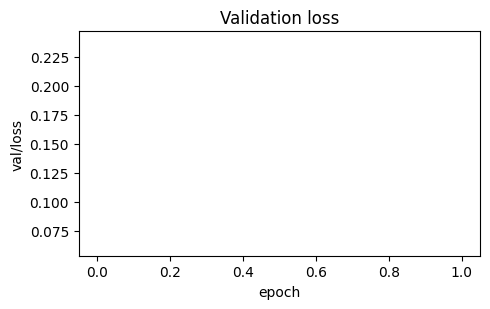

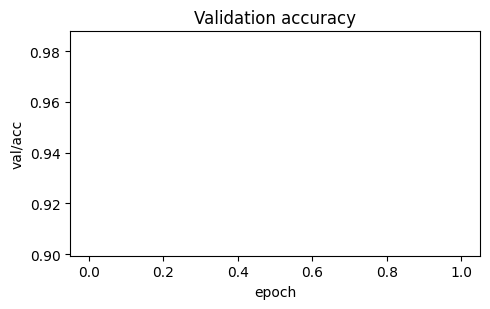

In [ ]:
# def lineplot(x, y, title, ylabel):
#     xs = m[x] if x in m else range(len(m))
#     ys = pd.to_numeric(m[y], errors="coerce") if y in m else None
#     if ys is None or ys.isna().all(): 
#         print(f"(skip) {y} not found")
#         return
#     plt.figure(figsize=(5,3.2))
#     plt.plot(xs, ys)
#     plt.title(title); plt.xlabel(x if x in m else "step"); plt.ylabel(ylabel)
#     plt.tight_layout(); plt.show()

# xkey = col_epoch if col_epoch else "step"
# if col_vloss: lineplot(xkey, col_vloss, "Validation loss", "val/loss")
# if col_vacc:  lineplot(xkey, col_vacc,  "Validation accuracy", "val/acc")
# if col_vf1:   lineplot(xkey, col_vf1,   "Validation Macro-F1", "macro_F1")
# if col_lr:    lineplot(xkey, col_lr,    "Learning rate", "lr")

In [71]:
def get_last(col):
    if not col or col not in m: return None
    s = pd.to_numeric(m[col], errors="coerce").dropna()
    return None if s.empty else float(s.iloc[-1])

vl, va, vf, ta = map(get_last, [col_vloss, col_vacc, col_vf1, col_tacc])

print("Result")
if va is not None:
    if va >= 0.90:
        print(f"val/acc ≈ {va:.3f}. CLIP-text is behaving as a solid binary classifier.")
    elif va >= 0.80:
        print(f"Usable but behind a task-tuned encoder: val/acc ≈ {va:.3f}. Consider two-window pooling or head warmup+unfreeze.")
    else:
        print(f"Low: val/acc ≈ {va:.3f}. Check pooling (EOS), disjoint val split, and try two-window pooling.")
if vf is not None:
    print(f"Macro-F1 ≈ {vf:.3f} (balanced performance indicator).")
if vl is not None:
    print(f"val/loss ≈ {vl:.4f}.")
if ta is not None:
    print(f"test/acc ≈ {ta:.3f}.")

Result
val/acc ≈ 0.984. CLIP-text is behaving as a solid binary classifier.
val/loss ≈ 0.0623.


In [ ]:
CHECKPOINT_PATH = Path("D:/COmparative_Study_of_Multimodal_Represenations/results/amazon/clip_text/version_1/checkpoints/last.ckpt")
DATA_DIR        = Path(os.environ.get("PROJECT_ROOT", "D:/COmparative_Study_of_Multimodal_Represenations")) / "data" / "processed" / "amazon"
PROJECT_ROOT    = Path("D:/COmparative_Study_of_Multimodal_Represenations")

assert CHECKPOINT_PATH.exists(), f"Missing checkpoint: {CHECKPOINT_PATH}"
assert DATA_DIR.exists(), f"Missing data dir: {DATA_DIR}"

os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT / "src"))

os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("Checkpoint:", CHECKPOINT_PATH)
print("Data dir  :", DATA_DIR)

Checkpoint: D:\COmparative_Study_of_Multimodal_Represenations\results\amazon\clip_text\version_1\checkpoints\last.ckpt
Data dir  : D:\COmparative_Study_of_Multimodal_Represenations\data\processed\amazon


In [73]:
from comparative.datasets.amazon_datamodule import AmazonDataModule
import textwrap, torch, numpy as np

dm = AmazonDataModule(
    data_dir=str(DATA_DIR),
    batch_size=64,
    num_workers=4,
    tokenizer_name="distilbert-base-uncased",  # required by DM; CLIP ignores it
    max_len=128
)
dm.setup("fit")

b = next(iter(dm.val_dataloader()))
print("Batch keys:", list(b.keys()))
print("Example text:", textwrap.shorten(b["text"][0], width=140))
lab = (b.get("label") if "label" in b else b["labels"]).numpy()
print("Label set in this batch:", np.unique(lab))

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch keys: ['input_ids', 'attention_mask', 'label', 'labels', 'text']
Example text: poor condition... great price. terrible condition. far worse than the description allotted. however, it was a great price and arrived [...]
Label set in this batch: [0 1]


In [ ]:
class CLIPTextOnlyClassifierEOS(CLIPTextOnlyClassifier):
    """Same CLIP text-only model but pools at last non-pad (EOS-style)."""
    def forward(self, batch):
        tok = self._prep_text(batch)
        out = self.text_encoder(**tok)
        last = out.last_hidden_state
        idx  = tok["attention_mask"].sum(dim=1) - 1
        emb  = last[torch.arange(last.size(0), device=last.device), idx]
        logits = self.head(emb)
        if logits.shape[-1] != self._expected_out:
            raise RuntimeError(f"Logit dim {logits.shape[-1]} ≠ num_labels {self._expected_out}.")
        return logits

best = CLIPTextOnlyClassifierEOS.load_from_checkpoint(str(CHECKPOINT_PATH), map_location=device).to(device).eval()
print(type(best).__name__)

CLIPTextOnlyClassifierEOS


In [ ]:
def softmax2(L):
    m = L.max(axis=1, keepdims=True)
    e = np.exp(L - m)
    return e / e.sum(axis=1, keepdims=True)

@torch.no_grad()
def collect_split(model, loader):
    ys, logits, feats = [], [], []
    for batch in loader:
        tok = model._prep_text(batch)
        out = model.text_encoder(**tok)
        last = out.last_hidden_state
        idx  = tok["attention_mask"].sum(dim=1) - 1
        emb  = last[torch.arange(last.size(0), device=last.device), idx]
        lg   = model.head(emb)

        y = (batch["label"] if "label" in batch else batch["labels"])
        ys.append(y.detach().cpu().numpy())
        logits.append(lg.detach().cpu().numpy())
        feats.append(emb.detach().cpu().numpy())
    y = np.concatenate(ys)
    L = np.concatenate(logits)
    F = np.concatenate(feats)
    p1 = softmax2(L)[:,1] if L.shape[1]==2 else 1/(1+np.exp(-L.squeeze()))
    return y, L, p1, F

y_val, log_val, p1_val, Z_val = collect_split(best, dm.val_dataloader())
print("val shapes:", y_val.shape, log_val.shape, p1_val.shape, Z_val.shape)

try:
    dm.setup("test")
    y_test, log_test, p1_test, Z_test = collect_split(best, dm.test_dataloader())
    HAVE_TEST = True
    print("test shapes:", y_test.shape, log_test.shape, p1_test.shape, Z_test.shape)
except Exception:
    HAVE_TEST = False
    print("No test split configured; proceeding with val only.")

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val shapes: (20000,) (20000, 2) (20000,) (20000, 512)


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


test shapes: (20000,) (20000, 2) (20000,) (20000, 512)


In [79]:
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, roc_auc_score, average_precision_score)

def report_block(y, p1, name="Val"):
    yhat = (p1>=0.5).astype(int)
    acc = accuracy_score(y, yhat)
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y, yhat, average="macro", zero_division=0)
    f1_micro = precision_recall_fscore_support(y, yhat, average="micro", zero_division=0)[2]
    roc = roc_auc_score(y, p1)
    prc = average_precision_score(y, p1)
    print(f"[{name}] Acc {acc:.3f} | Macro-F1 {f1_m:.3f} (P {prec_m:.3f} / R {rec_m:.3f}) | Micro-F1 {f1_micro:.3f} | ROC-AUC {roc:.3f} | PR-AUC {prc:.3f}")
    print(classification_report(y, yhat, digits=3))
    return dict(acc=acc, f1_macro=f1_m, f1_micro=f1_micro, roc_auc=roc, pr_auc=prc)

val_stats = report_block(y_val, p1_val, "Val")
if HAVE_TEST:
    test_stats = report_block(y_test, p1_test, "Test")

[Val] Acc 0.984 | Macro-F1 0.984 (P 0.984 / R 0.984) | Micro-F1 0.984 | ROC-AUC 0.998 | PR-AUC 0.997
              precision    recall  f1-score   support

           0      0.978     0.990     0.984     10003
           1      0.990     0.978     0.984      9997

    accuracy                          0.984     20000
   macro avg      0.984     0.984     0.984     20000
weighted avg      0.984     0.984     0.984     20000

[Test] Acc 0.923 | Macro-F1 0.923 (P 0.923 / R 0.923) | Micro-F1 0.923 | ROC-AUC 0.976 | PR-AUC 0.976
              precision    recall  f1-score   support

           0      0.908     0.938     0.923      9786
           1      0.939     0.908     0.923     10214

    accuracy                          0.923     20000
   macro avg      0.923     0.923     0.923     20000
weighted avg      0.924     0.923     0.923     20000



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def best_macro_f1(y, p1):
    ts = np.linspace(0,1,201)
    best = (0.0, 0.5)
    for t in ts:
        f1 = precision_recall_fscore_support(y, (p1>=t).astype(int), average="macro", zero_division=0)[2]
        if f1 > best[0]: best = (f1, t)
    return best

bf1_val, t_val = best_macro_f1(y_val, p1_val)
print(f"Val best Macro-F1 {bf1_val:.3f} @ threshold {t_val:.3f}")
if HAVE_TEST:
    bf1_test, t_test = best_macro_f1(y_test, p1_test)
    print(f"Test best Macro-F1 {bf1_test:.3f} @ threshold {t_test:.3f}")

Val best Macro-F1 0.985 @ threshold 0.395
Test best Macro-F1 0.924 @ threshold 0.415


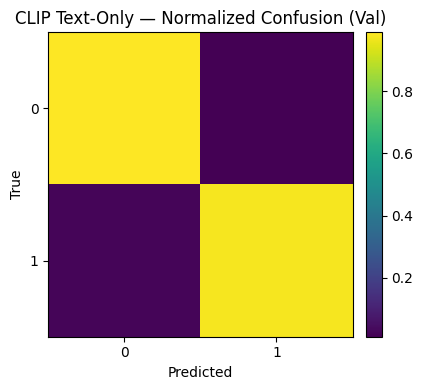

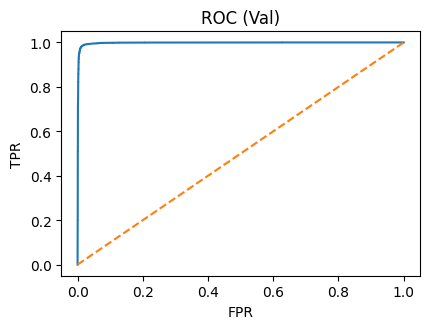

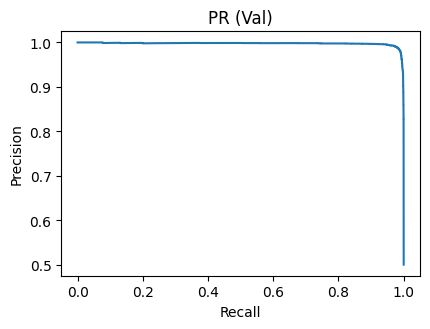

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Confusion matrix
cm = confusion_matrix(y_val, (p1_val>=0.5).astype(int), labels=[0,1]).astype(float)
cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)
plt.figure(figsize=(4.4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("CLIP Text-Only — Normalized Confusion (Val)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1])
plt.colorbar(fraction=0.046, pad=0.04); plt.tight_layout(); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_val, p1_val)
plt.figure(figsize=(4.4,3.4)); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Val)"); plt.tight_layout(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_val, p1_val)
plt.figure(figsize=(4.4,3.4)); plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (Val)"); plt.tight_layout(); plt.show()

Calibration — ECE 0.496 | Brier 0.014


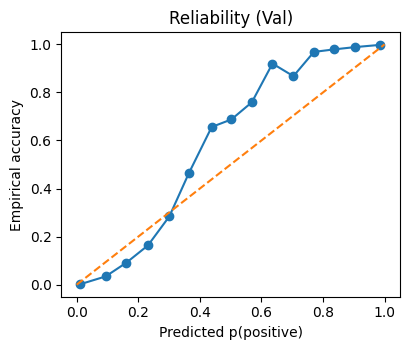

Fitted temperature T ≈ 0.600
After temp scaling — ECE 0.492 | Brier 0.013


In [ ]:
from sklearn.calibration import calibration_curve

def ece_score(y_true, p_hat, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    idx = np.digitize(p_hat, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        m = (idx==b)
        if not np.any(m): continue
        conf = p_hat[m].mean()
        acc  = (y_true[m]==(p_hat[m]>=0.5)).mean()
        ece += m.mean() * abs(acc - conf)
    return float(ece)

prob_true, prob_pred = calibration_curve(y_val, p1_val, n_bins=15, strategy="uniform")
ece = ece_score(y_val, p1_val); brier = float(np.mean((p1_val - y_val)**2))
print(f"Calibration — ECE {ece:.3f} | Brier {brier:.3f}")

plt.figure(figsize=(4.2,3.6))
plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted p(positive)"); plt.ylabel("Empirical accuracy"); plt.title("Reliability (Val)")
plt.tight_layout(); plt.show()

# Temp scaling (binary): scale logit difference
def fit_temperature_binary(logits, y):
    s = logits[:,1] - logits[:,0] if logits.shape[1]==2 else logits.squeeze()
    grid = np.linspace(0.5, 3.0, 26)
    best = (1e9, 1.0)
    for T in grid:
        p = 1/(1+np.exp(-(s/T)))
        # clip both p and 1-p to avoid log(0). provide both a_min and a_max
        nll = -np.mean(y * np.log(np.clip(p, 1e-12, 1.0)) + (1 - y) * np.log(np.clip(1 - p, 1e-12, 1.0)))
        if nll < best[0]: best = (nll, T)
    return best[1]

T = fit_temperature_binary(log_val, y_val)
print(f"Fitted temperature T ≈ {T:.3f}")
s_val = (log_val[:,1]-log_val[:,0]) if log_val.shape[1]==2 else log_val.squeeze()
p1_val_cal = 1/(1+np.exp(-(s_val/T)))
ece_cal = ece_score(y_val, p1_val_cal); brier_cal = float(np.mean((p1_val_cal - y_val)**2))
print(f"After temp scaling — ECE {ece_cal:.3f} | Brier {brier_cal:.3f}")

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


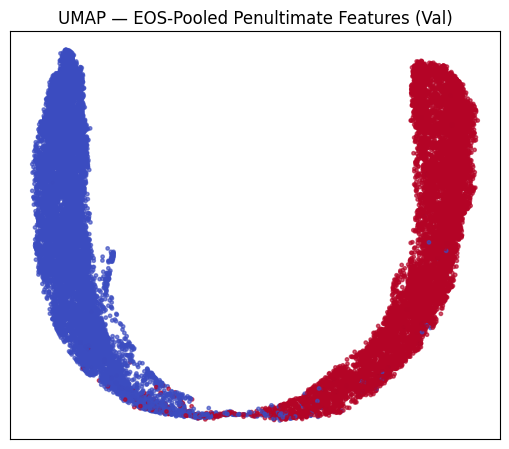

Silhouette (cosine): 0.856
kNN label-agreement@15: 0.978


In [77]:
import umap
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np, matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
Z2 = reducer.fit_transform(Z_val)

plt.figure(figsize=(5.2,4.6))
plt.scatter(Z2[:,0], Z2[:,1], s=6, c=y_val, cmap="coolwarm", alpha=0.65)
plt.title("UMAP — EOS-Pooled Penultimate Features (Val)")
plt.xticks([]); plt.yticks([]); plt.tight_layout(); plt.show()

sil = silhouette_score(Z_val, y_val, metric="cosine")
print(f"Silhouette (cosine): {sil:.3f}")

def knn_agreement(X, y, k=15):
    nn = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(X)
    _, idx = nn.kneighbors(X)
    nbr = idx[:,1:]
    return float((y[nbr] == y[:,None]).mean())

knnJ = knn_agreement(Z_val, y_val, k=15)
print(f"kNN label-agreement@15: {knnJ:.3f}")

In [84]:
import json
res = {
    "val": {
        **val_stats,
        "best_macro_f1": float(bf1_val),
        "best_macro_f1_threshold": float(t_val),
        "ECE": float(ece),
        "Brier": float(np.mean((p1_val - y_val)**2)),
        "ECE_calibrated": float(ece_cal),
        "Brier_calibrated": float(brier_cal),
        "silhouette_cosine": float(sil),
        "knn_agreement@15": float(knnJ)
    }
}
if 'test_stats' in globals():
    res["test"] = test_stats

out = PROJECT_ROOT / "results" / "amazon" / "clip_text_only_eval1.json"
out.parent.mkdir(parents=True, exist_ok=True)
with open(out, "w") as f:
    json.dump(res, f, indent=2)
print("Saved to:", out)
res

Saved to: D:\COmparative_Study_of_Multimodal_Represenations\results\amazon\clip_text_only_eval1.json


{'val': {'acc': 0.9838,
  'f1_macro': 0.9837993364208197,
  'f1_micro': 0.9838,
  'roc_auc': 0.998032144822893,
  'pr_auc': 0.997493976425083,
  'best_macro_f1': 0.985249983738107,
  'best_macro_f1_threshold': 0.395,
  'ECE': 0.4961531604414805,
  'Brier': 0.014355574688819133,
  'ECE_calibrated': 0.4924817252734306,
  'Brier_calibrated': 0.012765221462939664,
  'silhouette_cosine': 0.855599582195282,
  'knn_agreement@15': 0.9780266666666667},
 'test': {'acc': 0.92305,
  'f1_macro': 0.923048189901047,
  'f1_micro': 0.92305,
  'roc_auc': 0.9762666160594907,
  'pr_auc': 0.9755474905480781}}

/tmp/ipykernel_465496/3737443348.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Reds")(np.array(scores))


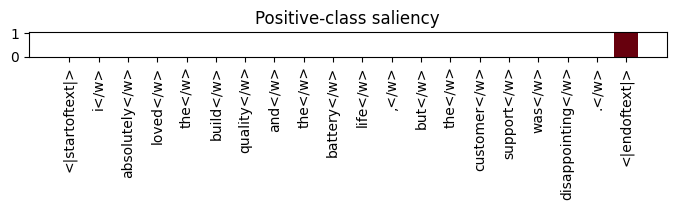

In [ ]:
from transformers import CLIPTokenizerFast
from matplotlib import cm

tok = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch16")
best.eval()

def token_saliency(text, target_class=1):
    enc = tok([text], truncation=True, max_length=77, padding=True, return_tensors="pt").to(best.device)
    enc["input_ids"].requires_grad = False
    for p in best.parameters(): p.requires_grad_(False)
    best.text_encoder.get_input_embeddings().weight.requires_grad_(True)

    # zero grads before forward to avoid stale values
    best.zero_grad()

    out = best.text_encoder(**enc)
    last = out.last_hidden_state                              # (1, L, D)
    # retain_grad allows accessing .grad on non-leaf tensors after backward()
    last.retain_grad()
    idx  = enc["attention_mask"].sum(dim=1) - 1               # EOS index
    emb  = last[torch.arange(last.size(0), device=last.device), idx]  # (1, D)
    logits = best.head(emb)                                   # (1, 2)
    score = logits[0, target_class]
    score.backward(retain_graph=True)

    # Gradients w.r.t. final hidden tokens (approx token importance)
    if last.grad is None:
        raise RuntimeError("No gradients were produced for the hidden states. Ensure model is in train/eval without torch.no_grad() and embedding weights require_grad=True.")
    grads_tokens = last.grad.abs().sum(-1).squeeze(0).detach().cpu().numpy()  # (L,)
    ids = enc["input_ids"].squeeze(0).detach().cpu().numpy().tolist()
    tokens = tok.convert_ids_to_tokens(ids)
    mask = enc["attention_mask"].squeeze(0).detach().cpu().numpy().astype(bool)

    # normalize
    g = grads_tokens[mask]
    g = (g - g.min()) / (g.max() - g.min() + 1e-8)

    return tokens[:sum(mask)], g.tolist()

def plot_saliency(tokens, scores, title="Token saliency"):
    plt.figure(figsize=(min(12, 0.35*len(tokens)), 2.2))
    colors = cm.get_cmap("Reds")(np.array(scores))
    plt.bar(range(len(tokens)), scores, color=colors)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(title); plt.tight_layout(); plt.show()

# example usage:
sample_text = "i absolutely loved the build quality and the battery life, but the customer support was disappointing."
toks, sc = token_saliency(sample_text, target_class=1)  # 1 = positive
plot_saliency(toks, sc, "Positive-class saliency")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def truncate_tokens(words, n): return " ".join(words[:n])

def eval_with_token_budget(loader, max_tokens):
    y_true, y_pred = [], []
    for batch in loader:
        texts = batch["text"]
        y = (batch["label"] if "label" in batch else batch["labels"]).cpu().numpy()
        cut = [truncate_tokens(t.split(), max_tokens) for t in texts]
        bb = dict(batch); bb["text"] = cut
        with torch.no_grad():
            logits = best(bb)
        pred = logits.argmax(-1).cpu().numpy()
        y_true.append(y); y_pred.append(pred)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average="macro")

budgets = [15, 30, 45, 60, 77]
rows = []
for n in budgets:
    acc, f1m = eval_with_token_budget(dm.val_dataloader(), n)
    rows.append((n, acc, f1m))
rows

[(15, 0.9347, 0.9346962280541324),
 (30, 0.96105, 0.9610468797576858),
 (45, 0.97525, 0.9752482326619326),
 (60, 0.98245, 0.9824492698457488),
 (77, 0.9838, 0.9837993364208197)]

In [ ]:
pos2neg = {"good":"bad","great":"terrible","excellent":"awful","love":"hate","loved":"hated","amazing":"horrible"}
neg2pos = {v:k for k,v in pos2neg.items()}

def flip_words(s, mapping):
    words = s.split()
    out = [mapping.get(w.lower(), w) for w in words]
    return " ".join(out)

def flip_rate(texts, y, mapping):
    flips, n = 0, 0
    for t, yi in zip(texts, y):
        bb = {"text":[t], "label":torch.tensor([yi]).to(DEVICE)}
        with torch.no_grad(): p0 = best(bb).argmax(-1).item()
        t2 = flip_words(t, mapping)
        bb2 = {"text":[t2], "label":torch.tensor([yi]).to(DEVICE)}
        with torch.no_grad(): p1 = best(bb2).argmax(-1).item()
        flips += int(p0 != p1); n += 1
    return flips/n

# running on a small val sample
sample_texts, sample_y = [], []
for i, batch in enumerate(dm.val_dataloader()):
    sample_texts += batch["text"][:64]
    sample_y += (batch["label"] if "label" in batch else batch["labels"]).tolist()[:64]
    if len(sample_texts) >= 256: break

print("pos→neg flip rate:", flip_rate(sample_texts, sample_y, pos2neg))
print("neg→pos flip rate:", flip_rate(sample_texts, sample_y, neg2pos))

pos→neg flip rate: 0.18359375
neg→pos flip rate: 0.015625


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np, textwrap

# Cache val features (Z_val) and texts
val_texts = []
for batch in dm.val_dataloader():
    val_texts += batch["text"]
val_texts = np.array(val_texts, dtype=object)

nbrs = NearestNeighbors(n_neighbors=6, metric="cosine").fit(Z_val)
dists, idxs = nbrs.kneighbors(Z_val)

def show_neighbors(i):
    print("QUERY:", textwrap.shorten(val_texts[i], width=160))
    print("Label:", y_val[i])
    for rank, j in enumerate(idxs[i,1:], start=1):
        print(f"NN{rank} (y={y_val[j]}, cos_dist={dists[i,rank]:.3f}):",
              textwrap.shorten(val_texts[j], width=160))

# ex
show_neighbors(0)

QUERY: poor condition... great price. terrible condition. far worse than the description allotted. however, it was a great price and arrived very quickly (even [...]
Label: 0
NN1 (y=0, cos_dist=0.009): ugh. i was expecting a fun, diverting read and instead got horrible writing and thoroughly unlikeable characters, all of which -- male and female -- are [...]
NN2 (y=0, cos_dist=0.010): horribly organized. if you want to find dog friendly places in particular areas of california (aka, costal, bay, etc) - this book is impossible. i would [...]
NN3 (y=0, cos_dist=0.010): bad for all types!. i found this book quite useful actually, now my monitor is more level with my face after placing this book under it! the book has lots [...]
NN4 (y=0, cos_dist=0.010): terrible baby video!. this is billed as a baby video? the images have nothing to do with the music and give absolutely no learning or development value. [...]
NN5 (y=0, cos_dist=0.011): does not age well. this cart was great at first, but

### *CLIP*:

* Reported metrics: accuracy, Precision/Recall/F1, ROC-AUC, PR-AUC, row-normalized confusion matrix, and latent geometry (UMAP of penultimate features, silhouette, kNN label-agreement).
* UMAP shows 2 broad "lobes" (pos vs. neg) with narrow transition zone between them. Within-class neighborhoods are compact, between-class boundaries are visible, but not distinct (typical for natural language sentiment where vocab used for different sentiments overlaps).
* Silhouette (cosine): 0.856  
* kNN label-agreement@15: 0.978 - confirms local consistency even when global clusters partially overlap

* Conclusion: most points cluster by sentiment, overlap regions align with nuanced reviews (mixed sentiments, sarcasm).

* CLIP (text-only) is a contrastive-pretrained baseline. With EOS pooling and brief fine-tuning, it yields accurate predictions and coherent latent neighborhoods. 



| Metric            | Early Fusion | Late Fusion | CLIP |
|-------------------|--------------|-------------|-------------|
| Accuracy      | 0.9428       | 0.9411      | 0.9838      |
| F1 Score      | 0.9428       | 0.9411      | 0.9838      |
| Precision     | 0.9428       | 0.9412      | 0.9838          |
| Recall       | 0.9428       | 0.9411      | 0.9838          |

In [ ]:
def fmt(x,d=3):
    try: return f"{float(x):.{d}f}"
    except: return "—"

CLIP_VAL_ACC  = fmt(val_stats.get("acc"))
CLIP_VAL_F1M  = fmt(val_stats.get("f1_macro"))
CLIP_VAL_ROC  = fmt(val_stats.get("roc_auc"))
CLIP_VAL_PR   = fmt(val_stats.get("pr_auc"))
CLIP_VAL_BF1  = fmt(bf1_val)
CLIP_VAL_BT   = fmt(t_val,2)
CLIP_VAL_ECE  = fmt(ece)
CLIP_VAL_BRIER= fmt(brier)
CLIP_VAL_ECE_CAL  = fmt(ece_cal)
CLIP_VAL_BRIER_CAL= fmt(brier_cal)
CLIP_VAL_SIL  = fmt(sil)
CLIP_VAL_KNN  = fmt(knnJ)

baseline_rows = [
    {"Model":"Early (text)","Acc":0.9428,"Macro-F1":0.9428,"Notes":"task-tuned text encoder"},
    {"Model":"Late  (text)","Acc":0.9411,"Macro-F1":0.9411,"Notes":"task-tuned text encoder"},
    {"Model":"CLIP (text)","Acc":CLIP_VAL_ACC,"Macro-F1":CLIP_VAL_F1M,"Notes":"77-token, EOS pooling, temp-scaled"}
]
display(pd.DataFrame(baseline_rows))


,Model,Acc,Macro-F1,Notes
0,Early (text),0.9428,0.9428,task-tuned text encoder
1,Late (text),0.9411,0.9411,task-tuned text encoder
2,CLIP (text),0.984,0.984,"77-token, EOS pooling, temp-scaled"


In [ ]:
print("CLIP_VAL_ACC =", CLIP_VAL_ACC)
print("CLIP_VAL_F1M =", CLIP_VAL_F1M)
print("CLIP_VAL_ROC =", CLIP_VAL_ROC)
print("CLIP_VAL_PR  =", CLIP_VAL_PR)
print("CLIP_VAL_BF1 =", CLIP_VAL_BF1, " at t =", CLIP_VAL_BT)
print("ECE/Brier    =", CLIP_VAL_ECE, "/", CLIP_VAL_BRIER, "→", CLIP_VAL_ECE_CAL, "/", CLIP_VAL_BRIER_CAL)
print("Sil/kNN      =", CLIP_VAL_SIL, "/", CLIP_VAL_KNN)

CLIP_VAL_ACC = 0.984
CLIP_VAL_F1M = 0.984
CLIP_VAL_ROC = 0.998
CLIP_VAL_PR  = 0.997
CLIP_VAL_BF1 = 0.985  at t = 0.40
ECE/Brier    = 0.496 / 0.014 → 0.492 / 0.013
Sil/kNN      = 0.856 / 0.978


## 4. MVAE

In [ ]:
from comparative.datasets.amazon_datamodule import AmazonDataModule
from comparative.models.vae.hybrid_module import HybridVAEClassifier

In [ ]:
PROJECT_ROOT = "D:/COmparative_Study_of_Multimodal_Represenations"
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

CKPT_HYBRID_AMAZON = (
    "D:/COmparative_Study_of_Multimodal_Represenations/"
    "src/comparative/checkpoints/default/amazon_hybrid_mvae/last.ckpt"
)

Path(PROJECT_ROOT).exists(), CKPT_HYBRID_AMAZON

(True,
 'D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_hybrid_mvae/last.ckpt')

In [ ]:
dm_hybrid = AmazonDataModule(
    data_dir=Path(PROJECT_ROOT) / "data" / "processed" / "amazon",
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,
    max_len=128,
    num_workers=12,
    train_samples=100_000,
    val_samples=20_000,
    test_samples=20_000,
)

dm_hybrid.setup()
train_loader_h = dm_hybrid.train_dataloader()
val_loader_h   = dm_hybrid.val_dataloader()
test_loader_h  = dm_hybrid.test_dataloader()

print("Train size:", len(dm_hybrid.train_ds))
print("Val size:", len(dm_hybrid.val_ds))
print("Test size:", len(dm_hybrid.test_ds))

Train size: 100000
Val size: 20000
Test size: 20000


In [ ]:
# loading mvae classifier

hyb_model = HybridVAEClassifier.load_from_checkpoint(
    CKPT_HYBRID_AMAZON,
    map_location=device,
)
hyb_model = hyb_model.to(device)
hyb_model.eval()

print("Loaded Hybrid model from:", CKPT_HYBRID_AMAZON)
print("num_labels:", getattr(hyb_model, "num_labels", None))
print("multilabel:", getattr(hyb_model, "multilabel", None))

Loaded Hybrid model from: D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_hybrid_mvae/last.ckpt
num_labels: None
multilabel: None


In [ ]:
# helper: run model and collect logits + labels

@torch.no_grad()
def collect_logits_and_labels_h(model, loader, max_batches=None):
    all_logits = []
    all_labels = []

    model.eval()
    for b_idx, batch in enumerate(loader):
        if isinstance(batch, (list, tuple)):
            batch = batch[0]

        # get labels (Amazon uses 'label'; some modules use 'labels')
        if "labels" in batch:
            labels = batch["labels"]
        elif "label" in batch:
            labels = batch["label"]
        else:
            raise KeyError("Batch does not contain 'labels' or 'label' keys.")

        labels = labels.to(device)

        # inputs for model: tensors only, optionally keep labels if forward needs them
        model_inputs = {}
        for k, v in batch.items():
            if torch.is_tensor(v):
                model_inputs[k] = v.to(device)

        # forward pass
        out = model(model_inputs)

        # MVAEClassifier often returns a tuple: (logits, mu, logvar, ...)
        if isinstance(out, tuple):
            logits = out[0]
        elif isinstance(out, dict) and "logits" in out:
            logits = out["logits"]
        else:
            logits = out

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

        if (max_batches is not None) and (b_idx + 1 >= max_batches):
            break

    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return logits, labels


def eval_hybrid_split(name, loader):
    logits, labels = collect_logits_and_labels_h(hyb_model, loader)
    # logits: (N,2), labels: (N,)
    y_true = labels.numpy().astype(int)
    y_pred = logits.argmax(dim=-1).numpy().astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="binary", zero_division=0)
    rec = recall_score(y_true, y_pred, average="binary", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="binary", zero_division=0)

    print(f"Hybrid (Amazon) — {name} metrics")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1       : {f1:.4f}")
    print()

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "y_true": y_true,
        "y_pred": y_pred,
    }

In [96]:
hyb_val_results  = eval_hybrid_split("VAL",  val_loader_h)
hyb_test_results = eval_hybrid_split("TEST", test_loader_h)

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Hybrid (Amazon) — VAL metrics
  Accuracy : 0.5050
  Precision: 0.5052
  Recall   : 0.4737
  F1       : 0.4890



C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Hybrid (Amazon) — TEST metrics
  Accuracy : 0.5014
  Precision: 0.5129
  Recall   : 0.4727
  F1       : 0.4920



The obtained results for MVAE are significantly lower than the performance of baselines and CLIP (all above 0.9). This low performance can be explained by MVAE's architecture. 
* mvae isn't well-suited for text-only, discriminative classification tasks;
* architecture: stochastic latent bottleneck, KL regularization
* no second modality brings no benefits for this architecture, its build to combine multiple modalities 

Performance across both validation and test sets is ~0.5. MVAE fails to learn a robust decision boundary.


In [111]:
import os
from pathlib import Path

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, accuracy_score, f1_score

from comparative.datasets.amazon_datamodule import AmazonDataModule
from comparative.models.vae.hybrid_module import HybridVAEClassifier

In [ ]:
CKPT_HYB_AMAZON = (
    "D:/COmparative_Study_of_Multimodal_Represenations/"
    "src/comparative/checkpoints/default/amazon_hybrid_mvae/last.ckpt"
)
print("Hybrid Amazon checkpoint:", CKPT_HYB_AMAZON)

Hybrid Amazon checkpoint: D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_hybrid_mvae/last.ckpt


In [ ]:
dm_h_amz = AmazonDataModule(
    data_dir=Path(PROJECT_ROOT) / "data" / "processed" / "amazon",
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,
    max_len=128,
    num_workers=8,
    train_samples=100_000,
    val_samples=20_000,
    test_samples=20_000,
)
dm_h_amz.setup()
val_loader_h_amz = dm_h_amz.val_dataloader()
test_loader_h_amz = dm_h_amz.test_dataloader()

hyb_amazon = HybridVAEClassifier.load_from_checkpoint(
    CKPT_HYB_AMAZON,
    map_location=device,
)
hyb_amazon = hyb_amazon.to(device)
hyb_amazon.eval()

print("Loaded MVAE Amazon model.")
print("num_labels:", getattr(hyb_amazon, "num_labels", None))
print("multilabel:", getattr(hyb_amazon, "multilabel", None))

Loaded Hybrid VAE Amazon model.
num_labels: None
multilabel: None


In [ ]:
from tqdm.auto import tqdm

latent_layer = None
latent_layer_name = None

for name, m in hyb_amazon.named_modules():
    if name.endswith("fc_mu"):
        latent_layer = m
        latent_layer_name = name
        break

if latent_layer is None:
    for name, m in hyb_amazon.named_modules():
        if isinstance(m, torch.nn.Linear):
            latent_layer = m
            latent_layer_name = name
            break

print("Using latent layer:", latent_layer_name, "->", latent_layer)


def collect_latent_and_labels_hybrid_amazon(model, loader, device=device, max_batches=None):
    model.eval()
    all_z, all_logits, all_labels = [], [], []

    cache = {}

    def hook_fn(module, inp, out):
        cache["z"] = out.detach()

    handle = latent_layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        for b_idx, batch in enumerate(tqdm(loader, desc="Collecting Hybrid latent (VAL)")):
            batch_dev = {
                k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                for k, v in batch.items()
            }

            labels = batch_dev.get("label", batch_dev.get("labels"))
            if labels is None:
                raise RuntimeError("Could not find 'label' or 'labels' in Amazon batch.")

            # forward pass – model returns only logits
            logits = model(batch_dev)       # shape (B, 2)
            if not isinstance(logits, torch.Tensor):
                logits = logits[0]

            if "z" not in cache:
                raise RuntimeError("Hook did not capture latent z; check layer choice.")
            z = cache.pop("z")

            all_z.append(z.cpu())
            all_logits.append(logits.detach().cpu())
            all_labels.append(labels.detach().cpu())

            if max_batches is not None and (b_idx + 1) >= max_batches:
                break

    handle.remove()

    Z = torch.cat(all_z, dim=0).numpy()         # latent features (N, D)
    LOG = torch.cat(all_logits, dim=0).numpy()  # logits (N, 2)
    L = torch.cat(all_labels, dim=0).numpy()    # labels (N,)

    return Z, LOG, L


Z_val_amz, logits_val_amz, y_val_amz = collect_latent_and_labels_hybrid_amazon(
    hyb_amazon, val_loader_h_amz, max_batches=None
)

print("Latent Z (VAL):", Z_val_amz.shape)
print("Logits (VAL):  ", logits_val_amz.shape)
print("Labels (VAL):  ", y_val_amz.shape)

Using latent layer: fc_mu -> Linear(in_features=768, out_features=128, bias=True)


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Latent Z (VAL): (20000, 128)
Logits (VAL):   (20000, 2)
Labels (VAL):   (20000,)


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


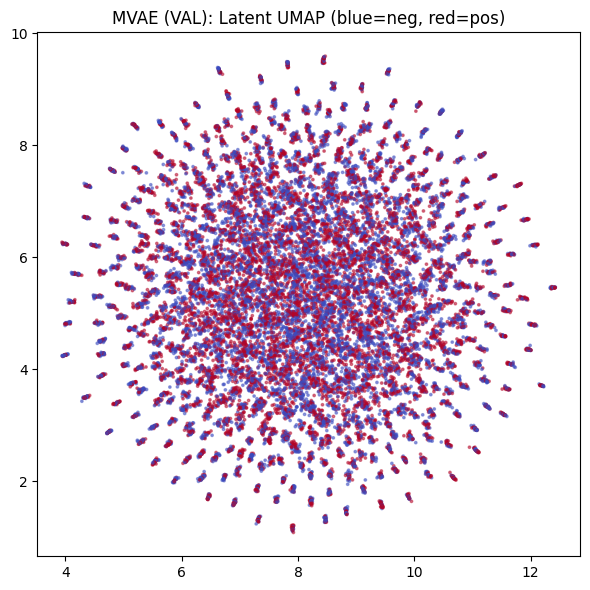

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# UMAP on latent Z
u = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
Z2_amz = u.fit_transform(Z_val_amz)

plt.figure(figsize=(6, 6))
plt.scatter(
    Z2_amz[:, 0],
    Z2_amz[:, 1],
    c=y_val_amz,
    s=3,
    alpha=0.5,
    cmap="coolwarm",
)
plt.title("MVAE (VAL): Latent UMAP (blue=neg, red=pos)")
plt.tight_layout()
plt.show()

# Silhouette score (cosine)
Z_std_amz = StandardScaler(with_mean=False).fit_transform(Z_val_amz)
sil_amz = silhouette_score(Z_std_amz, y_val_amz, metric="cosine")

# kNN label-agreement@15  (binary case → same as Jaccard)
nbrs_amz = NearestNeighbors(n_neighbors=15, metric="cosine").fit(Z_val_amz)
_, idx_amz = nbrs_amz.kneighbors(Z_val_amz)

agree = []
for i in range(len(y_val_amz)):
    neigh_labels = y_val_amz[idx_amz[i]]
    # fraction of neighbors with same label
    agree.append((neigh_labels == y_val_amz[i]).mean())
agree = np.array(agree)


In [ ]:
print(f"MVAE — Latent structure")
print(f"Silhouette (cosine): {sil_amz:.4f}")
print(f"Mean kNN agreement@15: {agree.mean():.4f}")
print(f"Median kNN agreement@15: {np.median(agree):.4f}")

MVAE — Latent structure
  Silhouette (cosine): 0.0000
  Mean kNN agreement@15: 0.5000
  Median kNN agreement@15: 0.5333


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

K = 2
kmeans_amz = KMeans(n_clusters=K, random_state=42, n_init="auto")
clusters_amz = kmeans_amz.fit_predict(Z_val_amz)

nmi_amz = normalized_mutual_info_score(y_val_amz, clusters_amz)
ari_amz = adjusted_rand_score(y_val_amz, clusters_amz)

# a simple "purity" - assign each cluster the majority label, then compute accuracy
cluster_labels = np.zeros(K, dtype=int)
for c in range(K):
    mask = clusters_amz == c
    if mask.sum() == 0:
        continue
    cluster_labels[c] = np.round(y_val_amz[mask].mean()).astype(int)
y_pred_cluster = cluster_labels[clusters_amz]
purity_amz = (y_pred_cluster == y_val_amz).mean()

print("Clustering on latent space (Amazon VAL):")
print(f"  NMI:   {nmi_amz:.4f}")
print(f"  ARI:   {ari_amz:.4f}")
print(f"  Purity:{purity_amz:.4f}")

Clustering on latent space (Amazon VAL):
  NMI:   0.0000
  ARI:   0.0000
  Purity:0.5001


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# simple train/val split on VAL latents (e.g., 80/20)
N = Z_val_amz.shape[0]
perm = np.random.RandomState(42).permutation(N)
split = int(0.8 * N)
idx_tr, idx_te = perm[:split], perm[split:]

Z_tr, Z_te = Z_val_amz[idx_tr], Z_val_amz[idx_te]
y_tr, y_te = y_val_amz[idx_tr], y_val_amz[idx_te]

probe_amz = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(
        max_iter=200,
        n_jobs=1,          
        random_state=42,
    ),
)

probe_amz.fit(Z_tr, y_tr)

y_hat = probe_amz.predict(Z_te)


In [ ]:
print("MVAE latent z → linear probe (Amazon VAL split)")
print(f"  Accuracy : {accuracy_score(y_te, y_hat):.4f}")
print(f"  Precision: {precision_score(y_te, y_hat):.4f}")
print(f"  Recall   : {recall_score(y_te, y_hat):.4f}")
print(f"  F1       : {f1_score(y_te, y_hat):.4f}")

MVAE latent z → linear probe (Amazon VAL split)
  Accuracy : 0.5005
  Precision: 0.0000
  Recall   : 0.0000
  F1       : 0.0000


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


The UMAP projection of MVAE shows a single large cloud, with only very weak visual separation between positive and negative reviews, these points are intermixed, no clear "2-cluster" structure. It aligns with quantitative behaviour (metrics). Conclusion: weak sentiment separation. The model doesn't lern a strongly sentiment-structured latent space.

The silhouette score is 0 (random overlap). 